In [1]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast/uncertainty


In [2]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Input, BatchNormalization, Lambda, 
                                     concatenate, Embedding, Reshape)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback, LearningRateScheduler

import wandb
from wandb.keras import WandbCallback

# own imports
from evaluation import Referee, load_data, select_dates, select_day_nums
from train import BatchCreator, Logger
from model_builder import get_pinball_losses, get_simple_dist_model, get_simple_dense_model
from flow import model_predict, denorm_preds, warp_preds_to_ref_form, plot_some, evaluate_model
from preprocess import preprocess, get_features, pandas_cat_data


# Setup file paths
data_dir = 'data/'
os.environ['DATA_DIR'] = data_dir
sub_dir = 'submissions_uncertainty/'
plt.rcParams['font.size'] = 13

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

In [4]:
def plot_confidence_series(quantile_preds, ax=None):
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(18, 6))

    x = np.arange(len(quantile_preds[0.5]))

    # plot median as thick line
    ax.plot(x, quantile_preds[0.5], 'k-', linewidth=2, label="Median")

    # plot true sales
    ax.plot(x, quantile_preds['true'], 'g-', linewidth=3, label='True')

    # plot confidence intervals
    conf_labels = ['50%', '67%', '95%', '99%']
    for i in range(4):
        q1 = quantiles[i]
        q2 = quantiles[-i-1]
        ax.fill_between(x, quantile_preds[q1], quantile_preds[q2], color='C0', alpha=(i+1)*0.2,
                       label=conf_labels[i])

    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(0)
    ax.set_xlabel("Predicted day")
    ax.set_ylabel("Predicted number of sales")
    ax.set_title(quantile_preds['label'])
    ax.legend()

def plot_some_confidence_intervals(df, val_batch_creator, level, data_dir='data/', num=9, plot_shape=(3, 3)):
    indices = range(num)
    norm = pd.read_csv(data_dir + 'prep/norm_level_{}.csv'.format(level))
    
    f, axes = plt.subplots(nrows=plot_shape[0], ncols=plot_shape[1], figsize=(18, 6*plot_shape[0]))
    
    for idx, ax in zip(indices, np.ravel(axes)):
        quantile_preds = {}
        d_cols = select_day_nums(df, as_int=False)

        for i, q in enumerate(quantiles):
            selected_series = df.loc[df['quantile'] == q].iloc[idx]
            quantile_preds[q] = selected_series[d_cols].values.astype(float)
        
        series_id = "_".join(selected_series['id'].split('_')[0:-2]) # e.g. FOODS_1_010_X_0.995_evaluation
        true_sales = val_batch_creator.df.loc[(val_batch_creator.df['id'] == series_id), 'demand']
        series_norm = norm.loc[norm['id'] == series_id].norm.values[0]
        quantile_preds['true'] = (true_sales * series_norm).values
        quantile_preds['label'] = series_id

        # plot
        plot_confidence_series(quantile_preds, ax=ax)
    
    plt.tight_layout()
    plt.show()

# Distribution layer performance - level 10

In [5]:
# Load in the data set
calendar, sales_train_validation, sell_prices = load_data()

sales_true = select_dates(sales_train_validation, day_end=1913, num_days=28, include_metadata=True)
sales_train = select_dates(sales_train_validation, day_start=1, num_days=1913-28, include_metadata=True)

ref = Referee(sales_true, sales_train, sell_prices, calendar, verbose=True)

Initializing Referee
Converting true sales to quantile form
Calculating weights for each level...
Calculating scale for each level...
Finished setup.


In [6]:
level = 10

model_dir = 'models/uncertainty/hyper_opt/level_{}/'.format(level)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

## Read data

In [7]:
fn = data_dir + 'prep/level_{}_simple_fe_2011_01_29_2016_04_24_normalised_demand.pickle'.format(level)

# check if already preprocessed
if os.path.exists(fn):
    data = pd.read_pickle(fn)
else:
    # choose number of years to include
    n_years = 6  # all
    
    # preform preprocessing
    data = preprocess(level=level, n_years=n_years, save_prepared_dataset=True, data_dir=data_dir)
    
# set categorical features
data, available_cat_features = pandas_cat_data(data)

# select features
sell_price_features = ('sell_price' in data.columns)
features = get_features(level=level, sell_price_features=sell_price_features)
print(features)

['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'shift_t28', 'shift_t29', 'shift_t30', 'rolling_std_t7', 'rolling_std_t30', 'rolling_std_t60', 'rolling_std_t90', 'rolling_std_t180', 'rolling_mean_t7', 'rolling_mean_t30', 'rolling_mean_t60', 'rolling_mean_t90', 'rolling_mean_t180', 'rolling_skew_t30', 'rolling_kurt_t30', 'year', 'month', 'week', 'day', 'dayofweek', 'is_year_end', 'is_year_start', 'is_quarter_end', 'is_quarter_start', 'is_month_end', 'is_month_start', 'is_weekend', 'cat_id', 'dept_id', 'item_id']


In [8]:
# Set the NaNs in these categories as a single element
for col in ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']:
    data[col] = data[col].cat.add_categories(-1).fillna(-1)

In [9]:
# re-index the categories to match the input of the Embedding layer
for col in available_cat_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

In [10]:
# re-set the categories as pandas categories for proper pd.get_dummies
for col in available_cat_features:
    data[col] = data[col].astype('category')

In [11]:
# set NaN values of shift_x, rolling_std_x, etc. to zero
nan_cols = data.isna().sum()
nan_cols = nan_cols[nan_cols != 0]
nan_cols

shift_t28              85372
shift_t29              88421
shift_t30              91470
rolling_std_t7        103666
rolling_std_t30       173793
rolling_std_t60       265263
rolling_std_t90       356733
rolling_std_t180      631143
rolling_mean_t7       103666
rolling_mean_t30      173793
rolling_mean_t60      265263
rolling_mean_t90      356733
rolling_mean_t180     631143
rolling_skew_t30     1296369
rolling_kurt_t30     1296369
dtype: int64

In [12]:
for col in tqdm(nan_cols.index, "Replacing NaN with zero"):
    mask = data[col].isna()
    data.loc[mask, col] = 0

Replacing NaN with zero: 100%|██████████| 15/15 [00:00<00:00, 43.06it/s]


## Setup training

In [13]:
# going to evaluate with the last 28 days
x_train = data[data['date'] <= '2016-03-27']
y_train = x_train['demand']
x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
y_val = x_val['demand']
test = data[(data['date'] > '2016-04-24')]

In [14]:
def get_generators(batch_size=1024):
    labels = ['demand']
    train_batch_creator = BatchCreator(x_train, features, labels, categorical_features=available_cat_features,
                                      batch_size=batch_size, check_nan=False)
    val_batch_creator = BatchCreator(x_val, features, labels, shuffle=False, ensure_all_samples=True,
                                     categorical_features=available_cat_features, batch_size=batch_size,
                                     check_nan=False)
    
    return train_batch_creator, val_batch_creator

# setup for training
train_batch_creator, val_batch_creator = get_generators()

# determine model input shape
x, y = next(train_batch_creator.flow())
INP_SHAPE = x[0].shape

# make losses
losses = get_pinball_losses()

# lazy evaluation of model
def lazy_evaluate_model(model):
    metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)
    return metrics, df

## Baselines

### Dist(256) model

In [213]:
# set batch size
train_batch_creator, val_batch_creator = get_generators()

# setup
model = get_simple_dist_model(inp_shape=INP_SHAPE, num_nodes=256)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
model.summary()
logger = Logger(val_batch_creator)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 3237)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          828928      input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          65792       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          65792       dense_1[0][0]                    
______________________________________________________________________________________________

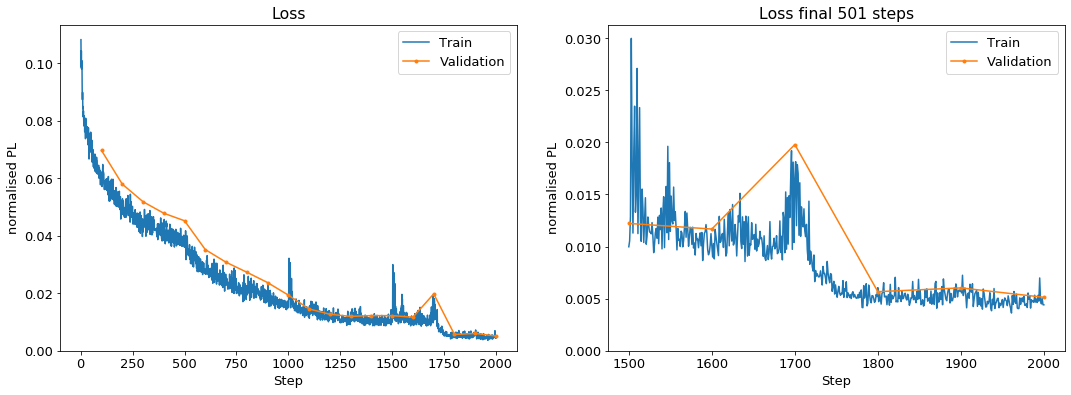

100/100 [==============================] - 45s 453ms/step - loss: 0.0049 - q0_loss: 4.9731e-05 - q1_loss: 1.7239e-04 - q2_loss: 6.3395e-04 - q3_loss: 7.9236e-04 - q4_loss: 0.0010 - q5_loss: 9.4264e-04 - q6_loss: 8.0010e-04 - q7_loss: 3.1261e-04 - q8_loss: 1.6778e-04 - val_loss: 0.0051 - val_q0_loss: 5.3512e-05 - val_q1_loss: 1.9548e-04 - val_q2_loss: 7.2248e-04 - val_q3_loss: 8.8997e-04 - val_q4_loss: 0.0011 - val_q5_loss: 9.7348e-04 - val_q6_loss: 8.1155e-04 - val_q7_loss: 2.7077e-04 - val_q8_loss: 1.1430e-04


In [214]:
lr_list = [1e-5, 1e-4, 3e-4, 1e-3]

for lr_block in lr_list:
    # set lr (without recompiling and losing momentum)
    def lr_scheduler(epoch, lr):
        return lr_block
    lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
    
    # train model
    history = model.fit(train_batch_creator.flow(), epochs=5, steps_per_epoch=100,
                        validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                        callbacks=[lr_callback, logger])

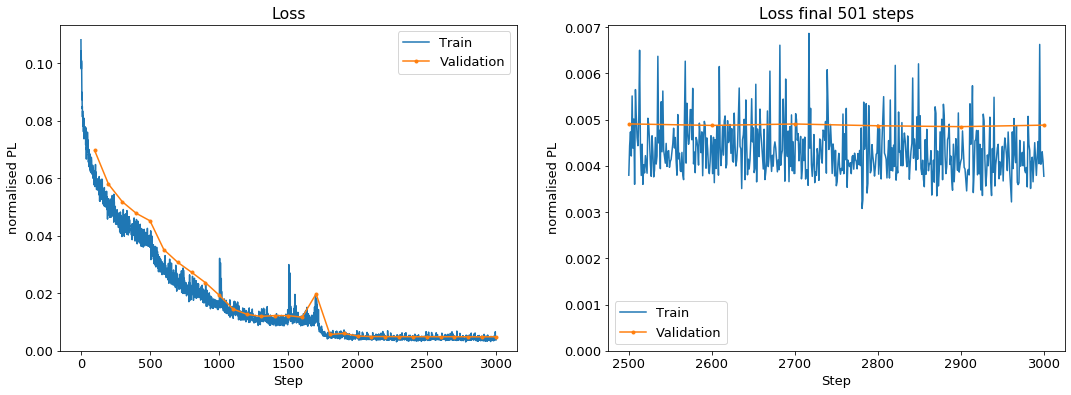

100/100 [==============================] - 46s 455ms/step - loss: 0.0042 - q0_loss: 3.5341e-05 - q1_loss: 1.3943e-04 - q2_loss: 5.4539e-04 - q3_loss: 6.9309e-04 - q4_loss: 9.1223e-04 - q5_loss: 8.0563e-04 - q6_loss: 6.7473e-04 - q7_loss: 2.5195e-04 - q8_loss: 1.3153e-04 - val_loss: 0.0049 - val_q0_loss: 5.3055e-05 - val_q1_loss: 1.7934e-04 - val_q2_loss: 6.5552e-04 - val_q3_loss: 8.2206e-04 - val_q4_loss: 0.0011 - val_q5_loss: 9.4764e-04 - val_q6_loss: 7.8654e-04 - val_q7_loss: 2.5960e-04 - val_q8_loss: 1.0990e-04


In [215]:
lr_list = [1e-4, 1e-5]

for lr_block in lr_list:
    # set lr (without recompiling and losing momentum)
    def lr_scheduler(epoch, lr):
        return lr_block
    lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
    
    # train model
    history = model.fit(train_batch_creator.flow(), epochs=5, steps_per_epoch=100,
                        validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                        callbacks=[lr_callback, logger])

In [216]:
model.save_weights(model_dir + 'model_dist256_stepped_lr.h5')
model.set_weights(logger.best_model)
model.save_weights(model_dir + 'model_dist256_stepped_lr_best_spl.h5')

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{10: 0.23255574501918438, 'WSPL': 0.23255574501918438}


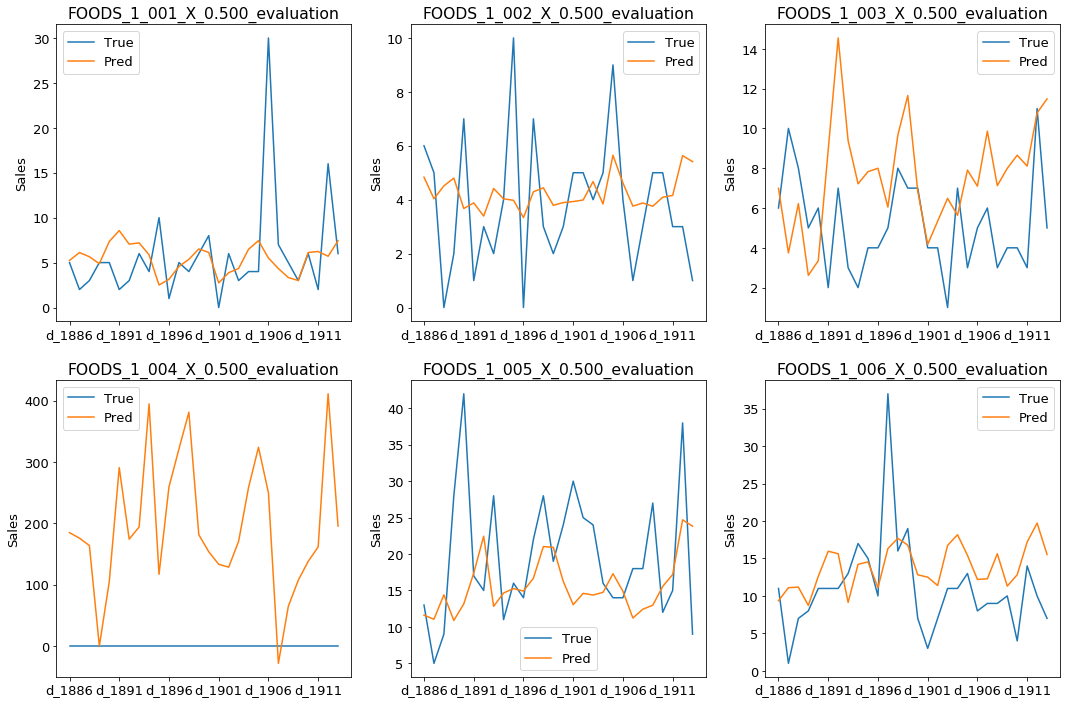

In [217]:
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

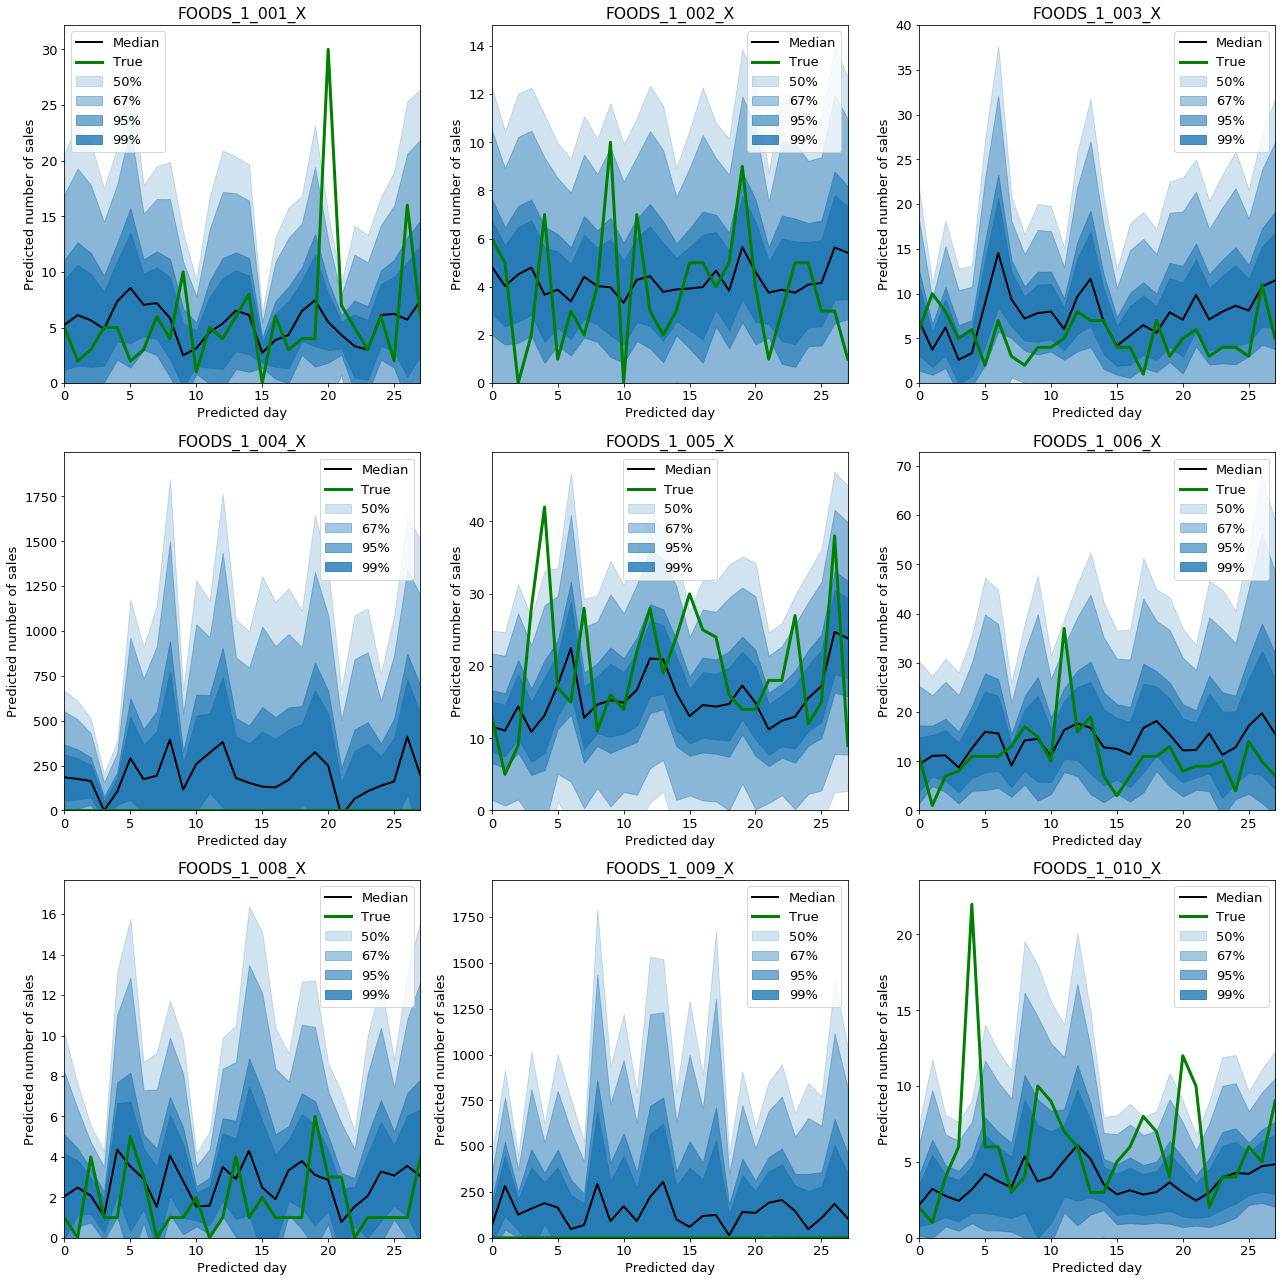

In [218]:
plot_some_confidence_intervals(df, val_batch_creator, level, data_dir)

### Dense(256, 9)

In [ ]:
# model setup
model = get_simple_dense_model(INP_SHAPE, num_nodes=256, bottleneck_nodes=9)
model.compile(optimizer=Adam(learning_rate=1e-3), loss=losses)
model.summary()

# setup metric tracking
logger = Logger(val_batch_creator)
# wandb.init(project='m5forecast', name="L10-dense-6yr")

# train model
history = model.fit(train_batch_creator.flow(), epochs=20, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])#, WandbCallback()])

# calculate WSPL and save metrics
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

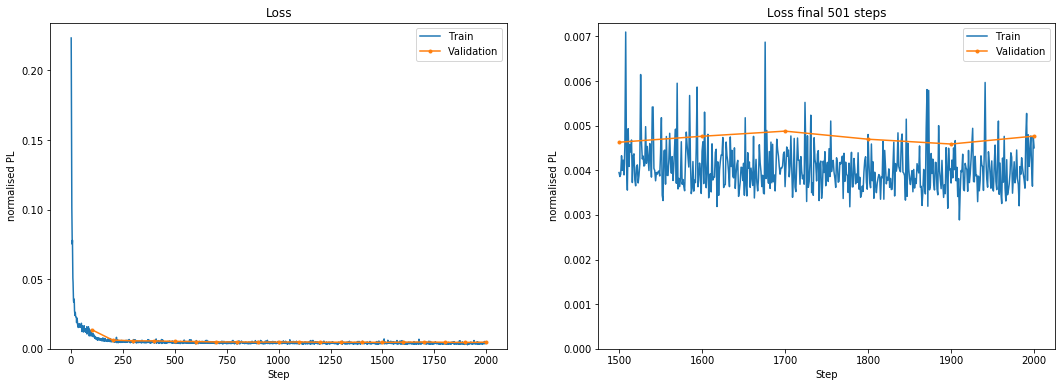

In [21]:
logger.plot()

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{10: 0.220605289842538, 'WSPL': 0.220605289842538}


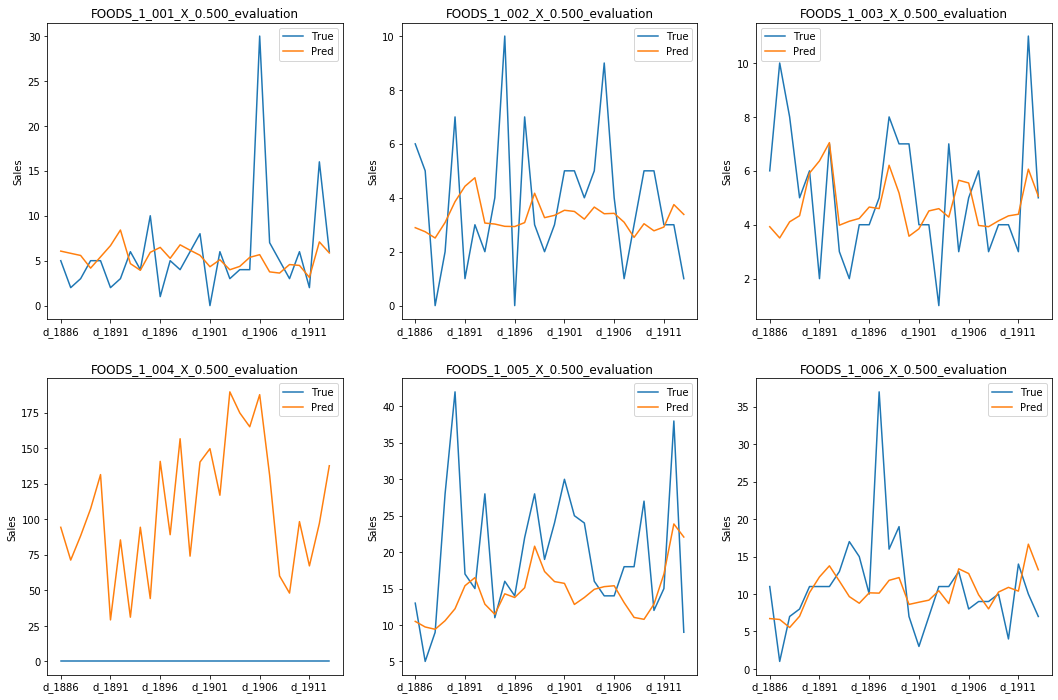

In [22]:
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

In [20]:
model.save_weights(model_dir + 'model_dense256_9_Adam1e-3_epoch20.h5')
model.set_weights(logger.best_model)
model.save_weights(model_dir + 'model_dense256_9_Adam1e-3_best_spl.h5')

## New Distribution layers

### Distribution described by $\mu, \sigma$, skewness and kurtosis

In [15]:
# from https://www.wolframalpha.com/input/?i=percentiles+of+a+normal+distribution
sigma_coefs = [-2.57583, -1.95996, -0.974114, -0.674, 0, 0.674, 0.9741114, 1.95996, 2.57583]

# Lambda layer: https://blog.paperspace.com/working-with-the-lambda-layer-in-keras/
def get_custom_layer(sigma_coefs,i):
    def custom_layer(tensor):
        tensor1 = tensor[0]
        tensor2 = tensor[1]
        kurtosis = tensor[2]
        skewness = tensor[3]
    
        
        sigma_coef_max=np.max(sigma_coefs)
        if (i in [1,2,3,5,6,7]): 
            
            # apply skewness (-1,1) to coefficient
            mod_sigma_coefs= sigma_coefs[i]+(sigma_coef_max-sigma_coefs[i])*skewness
            
            # shift x-coordinates towards mean for normalised kurtosis of 1
            return tensor1 + mod_sigma_coefs*(1-kurtosis) * tensor2 ;
        else: 
            # apply skewness
            if (i==4):
                # apply skewness
                spoofed_sigma_coefs_5=-sigma_coefs[3]+(sigma_coef_max+sigma_coefs[3])*skewness
                spoofed_sigma_coefs_3=sigma_coefs[3]+(sigma_coef_max-sigma_coefs[3])*skewness
                mod_sigma_coefs =spoofed_sigma_coefs_3+(spoofed_sigma_coefs_5-spoofed_sigma_coefs_3)/2

                # shift x-coordinates towards mean for normalised kurtosis of 1
                return tensor1 + mod_sigma_coefs*(1-kurtosis) * tensor2 ;
            
            # keep outer(0,8) and middle quantile(4) x-coordinate the same for kurtosis
            else:
                return tensor1 + sigma_coefs[i] * tensor2
    return custom_layer      
    
# dummy function to test the implemented skewness implementation
def apply_skewness(sigma_coefs, skewness):
    mod_sigma_coefs= np.zeros((len(sigma_coefs)),dtype=float)
    sigma_coef_max=np.max(sigma_coefs)
    for i in range(0,len(sigma_coefs)):
        if (i in [1,2,3,5,6,7]): 
            mod_sigma_coefs[i]=sigma_coefs[i]+(sigma_coef_max-sigma_coefs[i])*skewness
    
    # center new mean by computing sigma_coefs[5] using only sigma_coefs[3] (and 4) 
    spoofed_sigma_coefs_5=-sigma_coefs[3]+(sigma_coef_max+sigma_coefs[3])*skewness
    mod_sigma_coefs[4]=mod_sigma_coefs[3]+(spoofed_sigma_coefs_5-mod_sigma_coefs[3])/2    
    return mod_sigma_coefs        
    
def get_dist_model(inp_shape, sigma_coefs):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(16)(x)
    x = Dense(32)(x)
    x = Dense(64)(x)

    mu = Dense(1)(x)  # represents mu
    sigma = Dense(1)(x)  # represents sigma
    kurtosis = Dense(1)(x) # represents kurtosis
    skewness = Dense(1)(x) # represents skewness
    outs = []

    print(f'skewed sigma_coefs={apply_skewness(sigma_coefs,0.4)}')
    print(f'skewed sigma_coefs={apply_skewness(sigma_coefs,-0.4)}')
    
    for i, sigma_coef in enumerate(sigma_coefs):
        custom_layer = get_custom_layer(sigma_coefs=sigma_coefs,i=i)
        out_q = Lambda(custom_layer, name="q{}".format(i))([mu, sigma, kurtosis,skewness])
        outs.append(out_q)

    model = Model(inputs=inp, outputs=outs) 

    return model

In [14]:
model = get_dist_model(inp_shape=INP_SHAPE, sigma_coefs=sigma_coefs)
model.compile(optimizer="adam", loss=losses)
model.summary()

skewed sigma_coefs=[ 0.         -0.145644    0.4458636   0.625932    1.030332    1.434732
  1.61479884  2.206308    0.        ]
skewed sigma_coefs=[ 0.         -3.774276   -2.3940916  -1.973932   -1.030332   -0.086732
  0.33342396  1.713612    0.        ]
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 3237)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           51808       input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           544         dense[0][0]                      
____________________________________

In [ ]:
# setup metric tracking
logger = Logger(val_batch_creator)
wandb.init(project='m5forecast', name="L10-dist-skew-kurt")

# train model
history = model.fit(train_batch_creator.flow(), epochs=20, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger, WandbCallback()])

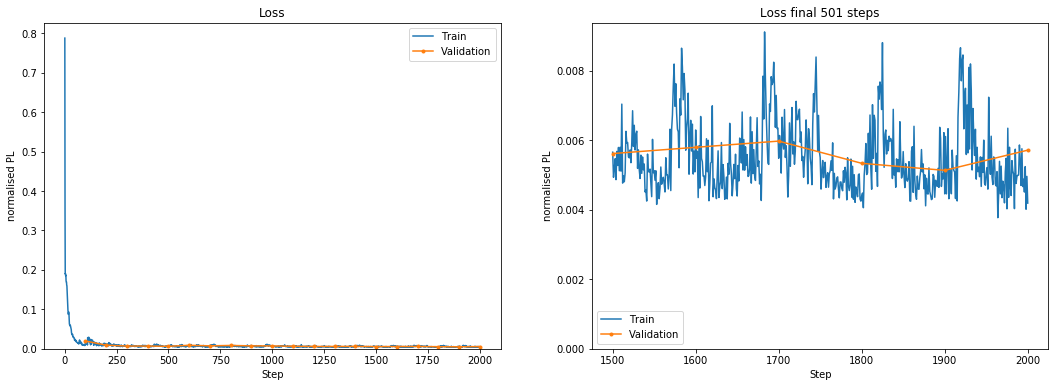

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{10: 0.27170080014124376, 'WSPL': 0.27170080014124376}


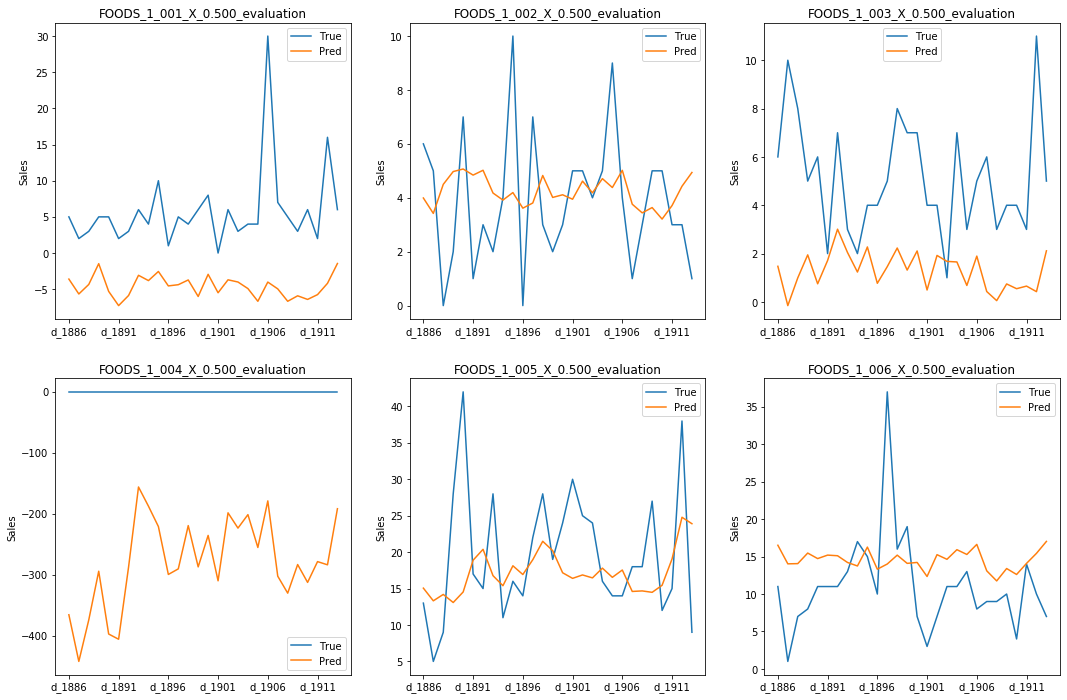

In [16]:
# show metrics
logger.plot()

# calculate WSPL and save metrics
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

#### Increase model size and set nonlinearity

In [16]:
def get_variable_dist_model(inp_shape, sigma_coefs, num_nodes=64):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(num_nodes, activation='relu')(x)
    x = Dense(num_nodes, activation='relu')(x)
    x = Dense(num_nodes, activation='relu')(x)

    mu = Dense(1)(x)  # represents mu
    sigma = Dense(1)(x)  # represents sigma
    kurtosis = Dense(1)(x) # represents kurtosis
    skewness = Dense(1)(x) # represents skewness
    outs = []

    print(f'skewed sigma_coefs={apply_skewness(sigma_coefs,0.4)}')
    print(f'skewed sigma_coefs={apply_skewness(sigma_coefs,-0.4)}')
    
    for i, sigma_coef in enumerate(sigma_coefs):
        custom_layer = get_custom_layer(sigma_coefs=sigma_coefs,i=i)
        out_q = Lambda(custom_layer, name="q{}".format(i))([mu, sigma, kurtosis, skewness])
        outs.append(out_q)

    model = Model(inputs=inp, outputs=outs) 

    return model

In [18]:
model = get_variable_dist_model(inp_shape=INP_SHAPE, sigma_coefs=sigma_coefs, num_nodes=256)
model.compile(optimizer="adam", loss=losses)
model.summary()

skewed sigma_coefs=[ 0.         -0.145644    0.4458636   0.625932    1.030332    1.434732
  1.61479884  2.206308    0.        ]
skewed sigma_coefs=[ 0.         -3.774276   -2.3940916  -1.973932   -1.030332   -0.086732
  0.33342396  1.713612    0.        ]
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 3237)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          828928      input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          65792       dense[0][0]                      
____________________________________

In [ ]:
# setup metric tracking
logger = Logger(val_batch_creator)
wandb.init(project='m5forecast', name="L10-dist-skew-kurt-256x3-relu")

# train model
history = model.fit(train_batch_creator.flow(), epochs=10, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger, WandbCallback()])

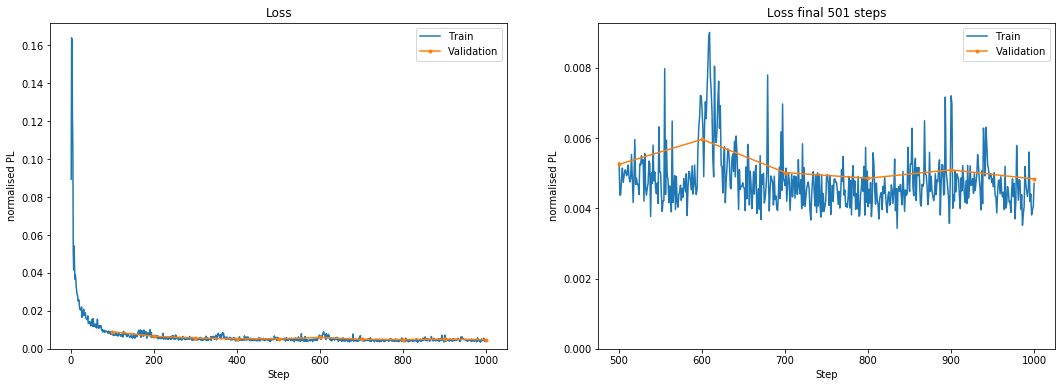

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{10: 0.23125081167227607, 'WSPL': 0.23125081167227607}


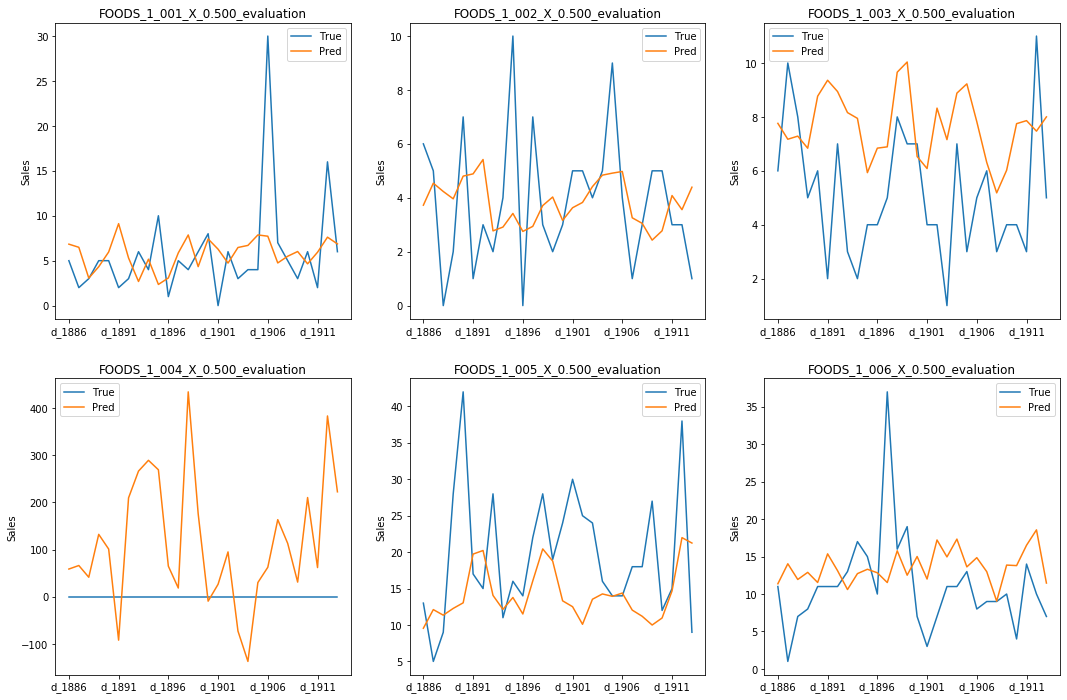

In [20]:
# show metrics
logger.plot()

# calculate WSPL and save metrics
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

#### Fine-tune

In [21]:
# set batch size to 25.000
train_batch_creator, val_batch_creator = get_generators(batch_size=25000)

# set lr to 1e-4 (without recompiling and losing momentum)
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, lr):
    return 1e-4
lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)

In [ ]:
# train model
history = model.fit(train_batch_creator.flow(), epochs=40, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbfacks=[lr_callback, logger, WandbCallback()])

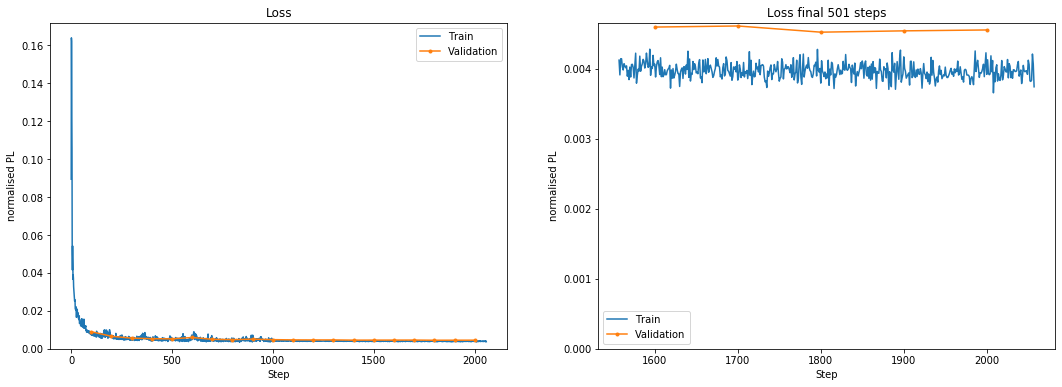

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{10: 0.2163685031989692, 'WSPL': 0.2163685031989692}


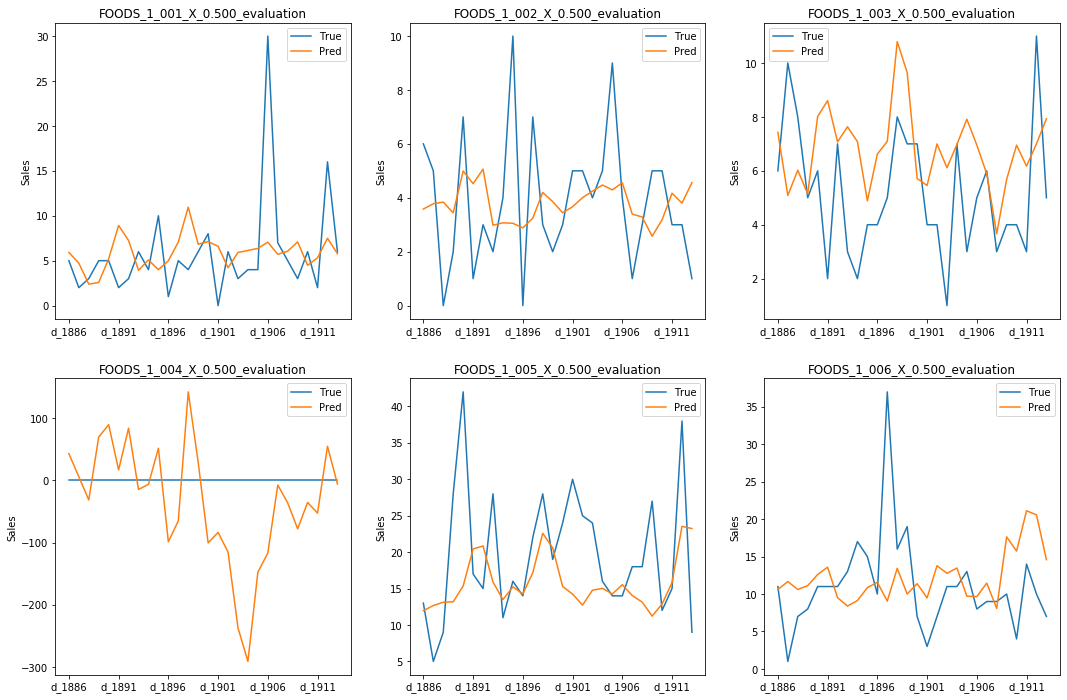

In [23]:
# show metrics
logger.plot()

# calculate WSPL and save metrics
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

In [ ]:
model.save_weights(model_dir + "dist_model_mean_sigma_skew_kurt.h5")
model.set_weights(logger.best_model)
model.save_weights(model_dir + "dist_model_mean_sigma_skew_kurt_best_spl.h5")

### Re-train network
Loading the model does not seem to work, so save its weights to file. 

In [17]:
model = get_variable_dist_model(inp_shape=INP_SHAPE, sigma_coefs=sigma_coefs, num_nodes=256)
model.compile(optimizer="adam", loss=losses)

skewed sigma_coefs=[ 0.         -0.145644    0.4458636   0.625932    1.030332    1.434732
  1.61479884  2.206308    0.        ]
skewed sigma_coefs=[ 0.         -3.774276   -2.3940916  -1.973932   -1.030332   -0.086732
  0.33342396  1.713612    0.        ]


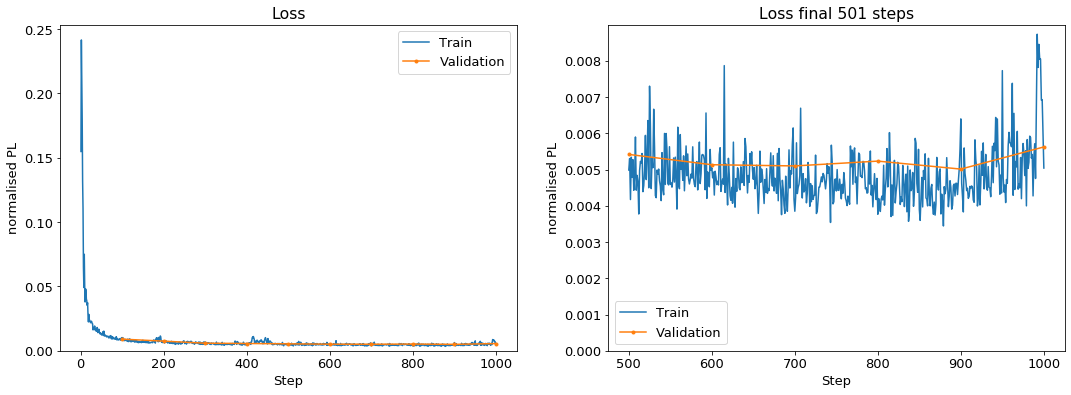

100/100 [==============================] - 47s 472ms/step - loss: 0.0052 - q0_loss: 7.0128e-05 - q1_loss: 1.9761e-04 - q2_loss: 7.2898e-04 - q3_loss: 8.8956e-04 - q4_loss: 0.0011 - q5_loss: 0.0010 - q6_loss: 8.5635e-04 - q7_loss: 3.1017e-04 - q8_loss: 1.3169e-04 - val_loss: 0.0056 - val_q0_loss: 1.0827e-04 - val_q1_loss: 3.0776e-04 - val_q2_loss: 7.5440e-04 - val_q3_loss: 9.0435e-04 - val_q4_loss: 0.0011 - val_q5_loss: 9.8568e-04 - val_q6_loss: 8.4876e-04 - val_q7_loss: 4.0207e-04 - val_q8_loss: 2.0732e-04


In [19]:
# setup metric tracking
logger = Logger(val_batch_creator)

# train model
history = model.fit(train_batch_creator.flow(), epochs=10, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

**Fine-tune**

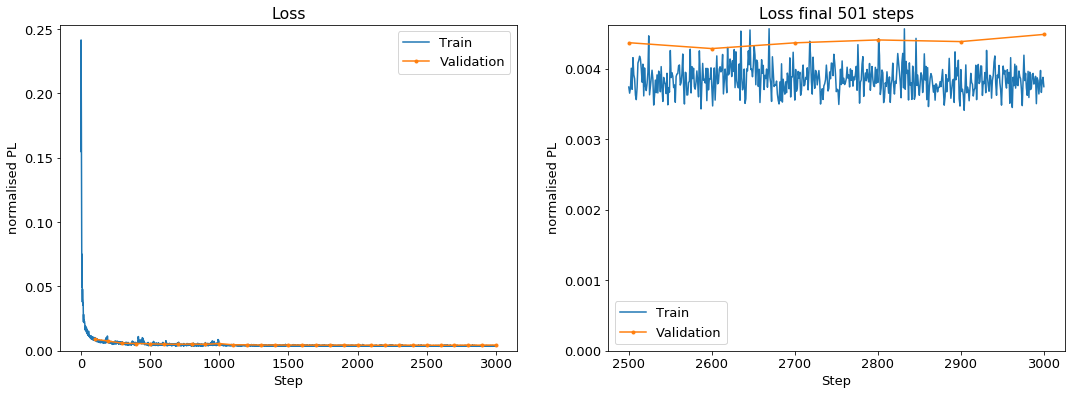

100/100 [==============================] - 82s 820ms/step - loss: 0.0038 - q0_loss: 3.9358e-05 - q1_loss: 1.2143e-04 - q2_loss: 5.0241e-04 - q3_loss: 6.4846e-04 - q4_loss: 8.5499e-04 - q5_loss: 7.4177e-04 - q6_loss: 6.1203e-04 - q7_loss: 2.0936e-04 - q8_loss: 8.2368e-05 - val_loss: 0.0045 - val_q0_loss: 4.9843e-05 - val_q1_loss: 1.6558e-04 - val_q2_loss: 6.2284e-04 - val_q3_loss: 7.8759e-04 - val_q4_loss: 0.0010 - val_q5_loss: 8.5683e-04 - val_q6_loss: 7.0497e-04 - val_q7_loss: 2.2366e-04 - val_q8_loss: 7.5357e-05


In [22]:
# set batch size to 25.000
train_batch_creator, val_batch_creator = get_generators(batch_size=5000)

# set lr to 1e-4 (without recompiling and losing momentum)
def lr_scheduler(epoch, lr):
    return 1e-4
lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)

# train model
history = model.fit(train_batch_creator.flow(), epochs=20, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[lr_callback, logger])

In [25]:
model.save_weights(model_dir + "dist_model_mean_sigma_skew_kurt.h5")
model.set_weights(logger.best_model)
model.save_weights(model_dir + "dist_model_mean_sigma_skew_kurt_best_spl.h5")

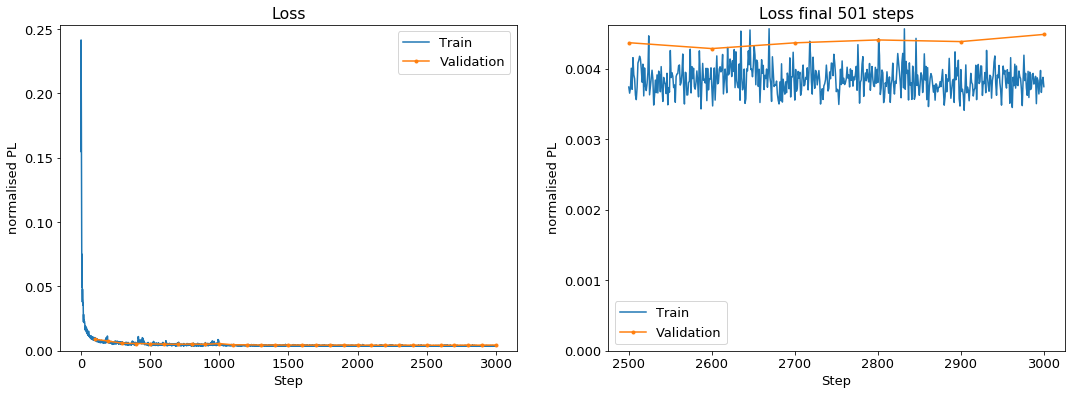

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{10: 0.21464396113876105, 'WSPL': 0.21464396113876105}


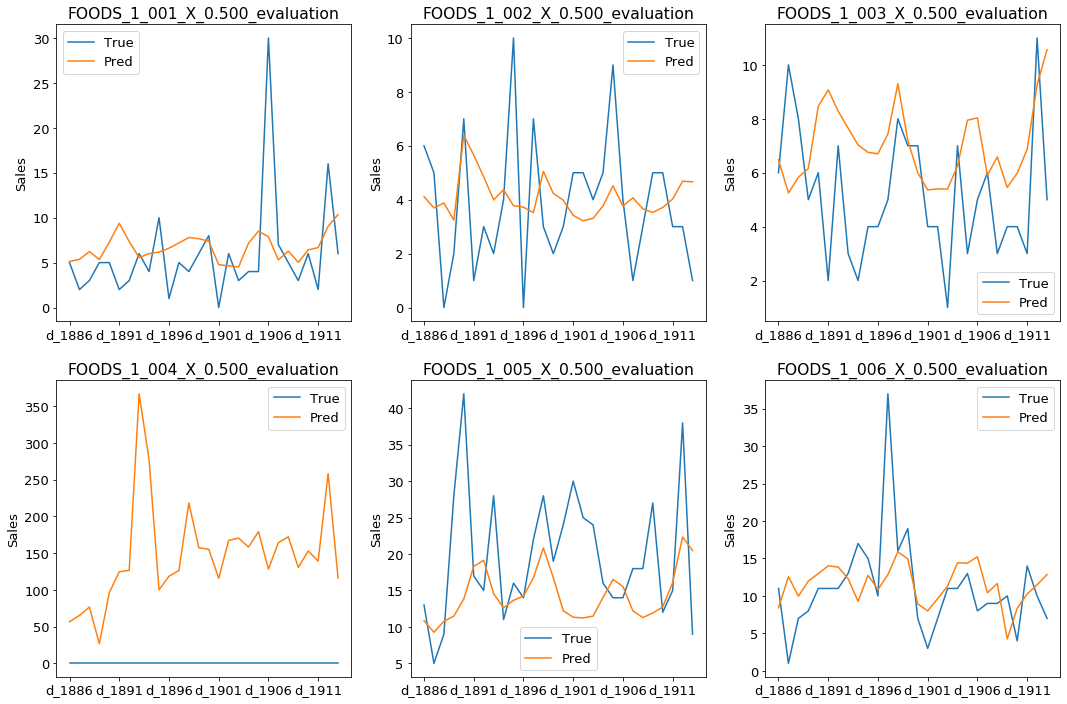

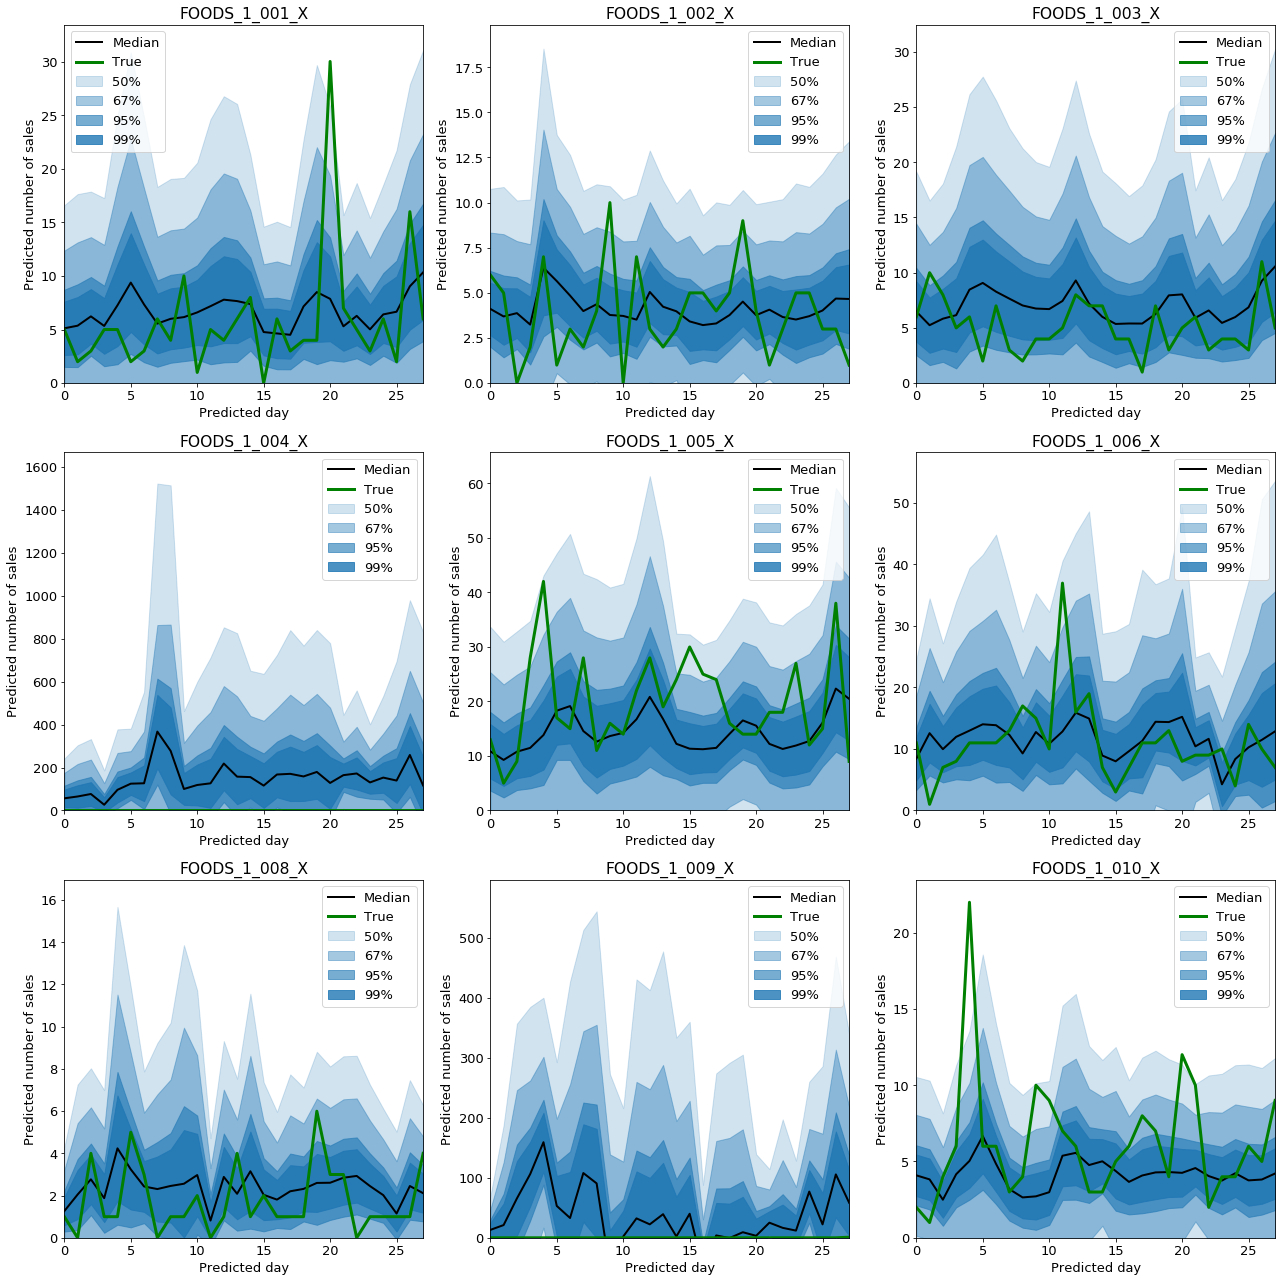

In [24]:
# show training metrics
logger.plot()

# evaluate
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)
plot_some_confidence_intervals(df, val_batch_creator, level, data_dir)

#### Test loading saved model

In [26]:
model = get_variable_dist_model(inp_shape=INP_SHAPE, sigma_coefs=sigma_coefs, num_nodes=256)
model.compile(optimizer="adam", loss=losses)
model.load_weights(model_dir + "dist_model_mean_sigma_skew_kurt_best_spl.h5")

skewed sigma_coefs=[ 0.         -0.145644    0.4458636   0.625932    1.030332    1.434732
  1.61479884  2.206308    0.        ]
skewed sigma_coefs=[ 0.         -3.774276   -2.3940916  -1.973932   -1.030332   -0.086732
  0.33342396  1.713612    0.        ]


In [27]:
model.evaluate(val_batch_creator)

18/18 [==============================] - 7s 385ms/step - loss: 0.0044 - q0_loss: 4.9267e-05 - q1_loss: 1.6198e-04 - q2_loss: 6.0798e-04 - q3_loss: 7.6987e-04 - q4_loss: 9.8109e-04 - q5_loss: 8.3755e-04 - q6_loss: 6.8543e-04 - q7_loss: 2.1137e-04 - q8_loss: 6.8982e-05


[0.004373514054653545,
 4.9267488e-05,
 0.00016197836,
 0.00060798496,
 0.00076986797,
 0.0009810873,
 0.0008375484,
 0.0006854315,
 0.00021136603,
 6.898193e-05]

### Direct prediction of coupled quantiles

This distribution is constructed such that the quantiles are in ordered fashion, cannot be zero, and have smooth derivatives. The activation $\exp$ is chosen in favour of ReLU to always have smooth derivatives (this is zero for ReLU with $a<0$). By construction, the complete distribution scales with the median quantile, and all quantiles have the nonzero constraint by choosing activation functions sigmoid or $\exp$ for the parameters defined below. 

Similar to the model above, the center quantile is predicted directly (i.e. with a single parameter). The other parameters are scaled versions of this, based on the calculation below. The quantiles are abbreviated as: $q_m = q_{0.5}$, $q_0 = q_{0.005}$, $q_1 = q_{0.025}$, $q_2 = q_{0.165}$, $q_3 = q_{0.25}$, $q_5 = q_{0.75}$, $q_6 = q_{0.835}$, $q_7 = q_{0.975}$, $q_8 = q_{0.995}$.  

The median:
$$
q_m = q_m, \text{with } q_m \in [0, \infty]\text{, by } q_m=\exp(a_4)
$$

The extremes, $q_0$ and $q_8$:  
$$
\begin{align}
q_0 &= \alpha \cdot q_m, &\text{with } \alpha \in [0, 1]\text{, by } \alpha=\text{sigmoid}(a_0)\\
q_8 &= (1 + \delta) \cdot q_m, &\text{with } \delta \in [0, \infty)\text{, by } \delta=\exp(a_9)\\
\end{align}
$$

The intermediate values are between these, with the relative posistion in the range $[0, 1]$:  
$$
\begin{align}
q_2 &= q_0 + \beta \cdot (q_m - q_0), &\text{with } \beta \in [0, 1]\text{, by } \beta=\text{sigmoid}(a_2)\\
    &= (\alpha + \beta - \alpha\cdot\beta)q_m\\
q_1 &= q_0 + \gamma (q_2 - q_0), &\text{with } \gamma \in [0, 1]\text{, by } \gamma=\text{sigmoid}(a_1)\\
    &= (\alpha + \gamma \beta - \alpha \beta \gamma)q_m
\end{align}
$$

The same method is applied for $q_3, q_5, q_6, q_7$, resulting in:
$$
\begin{align}
q_3 &= q_2 + \epsilon \cdot (q_m - q_2) &= (\alpha + \beta - \alpha \beta + \epsilon - [\alpha + \beta - \alpha\beta]\epsilon)q_m \\
q_6 &= q_m + \zeta (q_8-q_m) &= (1+\zeta \delta)q_m\\
q_5 &= q_m + \eta (q_6-q_m) &= (1+\eta \zeta \delta) q_m\\
q_7 &= q_6 + \theta (q_8-q_6) &= (1+\zeta \delta + \theta \delta+\theta\eta\zeta\delta)q_m
\end{align}
$$

In which $\epsilon, \zeta, \eta, \theta$ are in the interval $[0, 1]$ by setting the sigmoid as activation function. 

In [29]:
def get_custom_layer(i):
    def custom_layer(tensor):
        # unpack input
        qm = tensor[0]

        # parameters
        alpha   = tensor[1]
        beta    = tensor[2]
        gamma   = tensor[3]
        delta   = tensor[4]
        epsilon = tensor[5]
        zeta    = tensor[6]
        eta     = tensor[7]
        theta   = tensor[8]
        
        if i == 0:
            return alpha * qm
        elif i == 1:
            return (alpha + gamma*beta - alpha*beta*gamma) * qm
        elif i == 2:
            return (alpha + beta - alpha * beta) * qm
        elif i == 3:
            return (alpha + beta - alpha*beta + epsilon - (alpha + beta - alpha*beta)*epsilon) * qm
        elif i == 5:
            return (1 + eta*zeta*delta) * qm
        elif i == 6:
            return (1 + zeta*delta) * qm
        elif i == 7:
            return (1 + zeta*delta + theta*delta + theta*eta*zeta*delta)*qm
        elif i == 8:
            return (1 + delta) * qm
        
    return custom_layer


def get_direct_dist_model(inp_shape, num_nodes=256):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(num_nodes, activation='relu')(x)
    x = Dense(num_nodes, activation='relu')(x)
    x = Dense(num_nodes, activation='relu')(x)
    
    # direct prediction of median
    qm = Dense(1, name="q4", activation="exponential")(x)
    
    # setup parameters
    alpha   = Dense(1, name="alpha",   activation="sigmoid")(x)
    beta    = Dense(1, name="beta",    activation="sigmoid")(x)
    gamma   = Dense(1, name="gamma",   activation="sigmoid")(x)
    delta   = Dense(1, name="delta",   activation="exponential")(x)
    epsilon = Dense(1, name="epsilon", activation="sigmoid")(x)
    zeta    = Dense(1, name="zeta",    activation="sigmoid")(x)
    eta     = Dense(1, name="eta",     activation="sigmoid")(x)
    theta   = Dense(1, name="theta",   activation="sigmoid")(x)
    
    
    outs = []

    for i in range(9):
        if i == 4:
            out_q = qm
        else:
            custom_layer = get_custom_layer(i)
            params = [qm, alpha, beta, gamma, delta, epsilon, zeta, eta, theta]
            out_q = Lambda(custom_layer, name="q{}".format(i))(params)
        outs.append(out_q)
    
    model = Model(inputs=inp, outputs=outs) 

    return model

In [34]:
train_batch_creator, val_batch_creator = get_generators()

model = get_direct_dist_model(inp_shape=INP_SHAPE, num_nodes=256)
model.compile(optimizer=Adam(1e-5), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 3237)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          828928      input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          65792       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          65792       dense_1[0][0]                    
______________________________________________________________________________________________

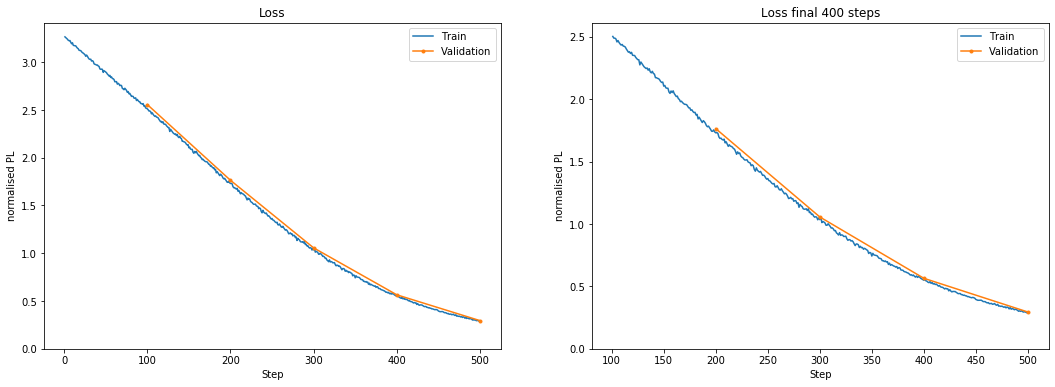

100/100 [==============================] - 48s 478ms/step - loss: 0.4052 - q0_loss: 0.0526 - q1_loss: 0.0637 - q2_loss: 0.0713 - q3_loss: 0.0777 - q4_loss: 0.0659 - q5_loss: 0.0377 - q6_loss: 0.0292 - q7_loss: 0.0059 - q8_loss: 0.0013 - val_loss: 0.2948 - val_q0_loss: 0.0361 - val_q1_loss: 0.0443 - val_q2_loss: 0.0513 - val_q3_loss: 0.0567 - val_q4_loss: 0.0497 - val_q5_loss: 0.0284 - val_q6_loss: 0.0221 - val_q7_loss: 0.0048 - val_q8_loss: 0.0014


In [35]:
# setup metric tracking
logger = Logger(val_batch_creator)

# train model
history = model.fit(train_batch_creator.flow(), epochs=5, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

**Increase lr after initial phase**

To $10^{-4}$

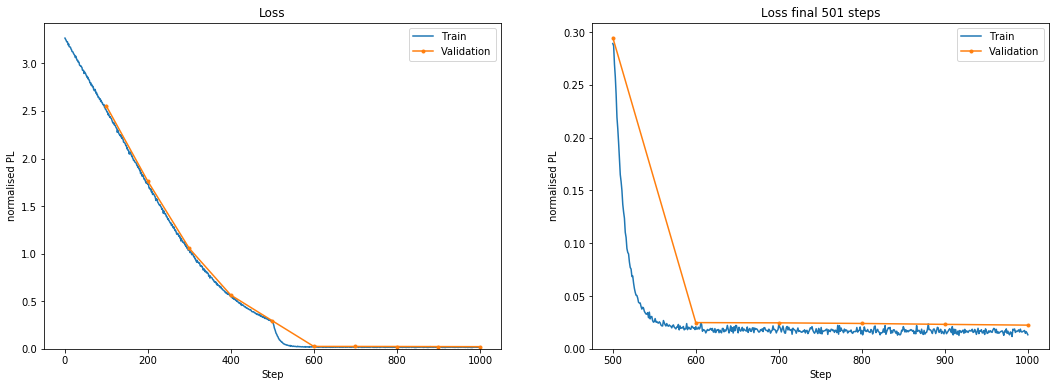

100/100 [==============================] - 47s 472ms/step - loss: 0.0163 - q0_loss: 2.0088e-04 - q1_loss: 3.0687e-04 - q2_loss: 9.8691e-04 - q3_loss: 0.0014 - q4_loss: 0.0026 - q5_loss: 0.0028 - q6_loss: 0.0029 - q7_loss: 0.0026 - q8_loss: 0.0026 - val_loss: 0.0224 - val_q0_loss: 9.9169e-05 - val_q1_loss: 2.4149e-04 - val_q2_loss: 0.0012 - val_q3_loss: 0.0017 - val_q4_loss: 0.0032 - val_q5_loss: 0.0040 - val_q6_loss: 0.0041 - val_q7_loss: 0.0038 - val_q8_loss: 0.0040


In [36]:
# set lr (without recompiling and losing momentum)
def lr_scheduler(epoch, lr):
    return 1e-4
lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)

# train model
history = model.fit(train_batch_creator.flow(), epochs=5, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[lr_callback, logger])

To $10^{-3}$

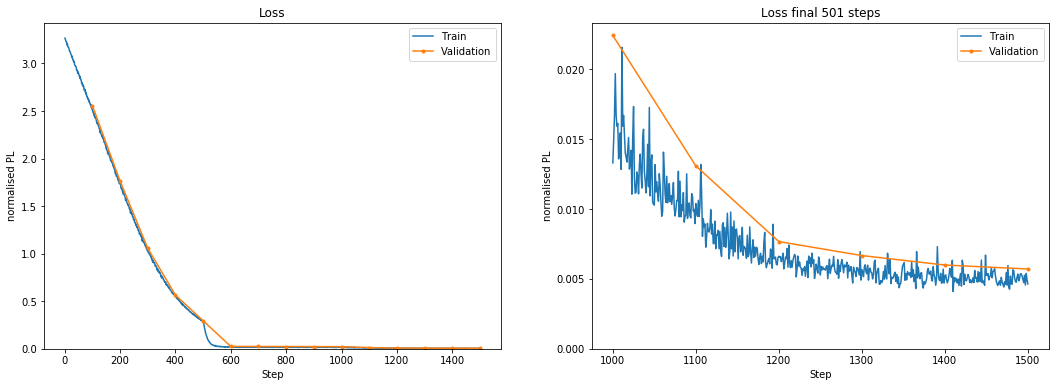

100/100 [==============================] - 48s 482ms/step - loss: 0.0051 - q0_loss: 4.6871e-05 - q1_loss: 1.3652e-04 - q2_loss: 6.7230e-04 - q3_loss: 8.6889e-04 - q4_loss: 0.0011 - q5_loss: 9.7179e-04 - q6_loss: 8.3743e-04 - q7_loss: 2.9222e-04 - q8_loss: 1.0821e-04 - val_loss: 0.0057 - val_q0_loss: 4.1439e-05 - val_q1_loss: 1.6554e-04 - val_q2_loss: 8.3705e-04 - val_q3_loss: 9.6072e-04 - val_q4_loss: 0.0012 - val_q5_loss: 0.0011 - val_q6_loss: 9.7127e-04 - val_q7_loss: 3.3309e-04 - val_q8_loss: 9.8229e-05


In [37]:
# set lr (without recompiling and losing momentum)
def lr_scheduler(epoch, lr):
    return 1e-3
lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)

# train model
history = model.fit(train_batch_creator.flow(), epochs=5, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[lr_callback, logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{10: 0.27289993108213395, 'WSPL': 0.27289993108213395}


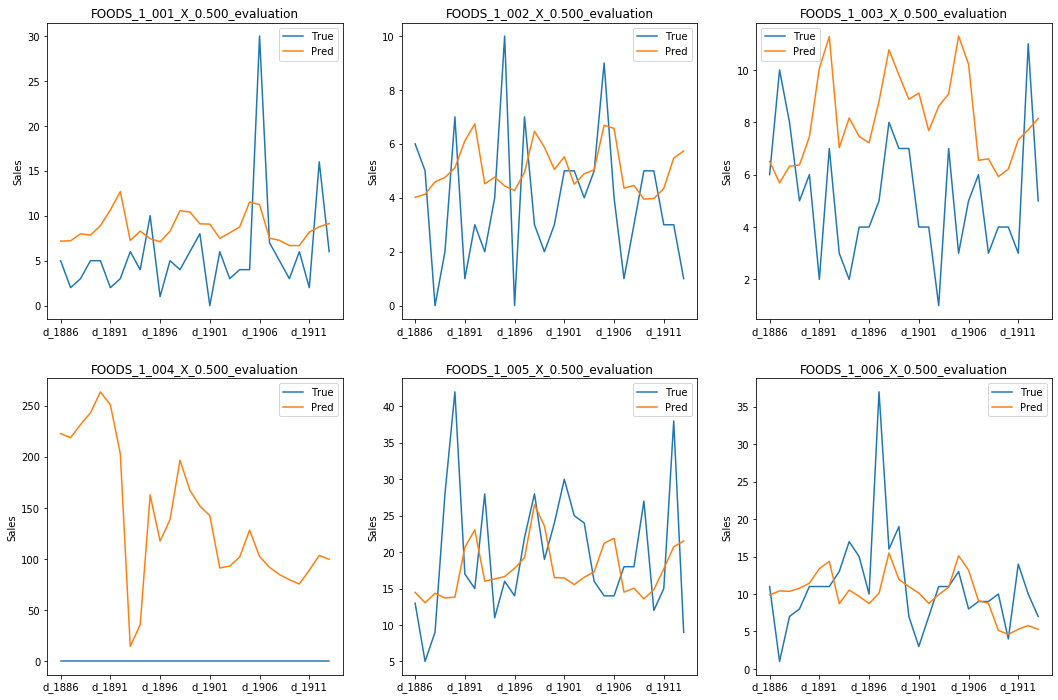

In [38]:
model.save_weights(model_dir + "model_direct_dist_256_manual_lr_to_1e-3.h5")
# calculate WSPL and save metrics
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

To $10^{-2}$

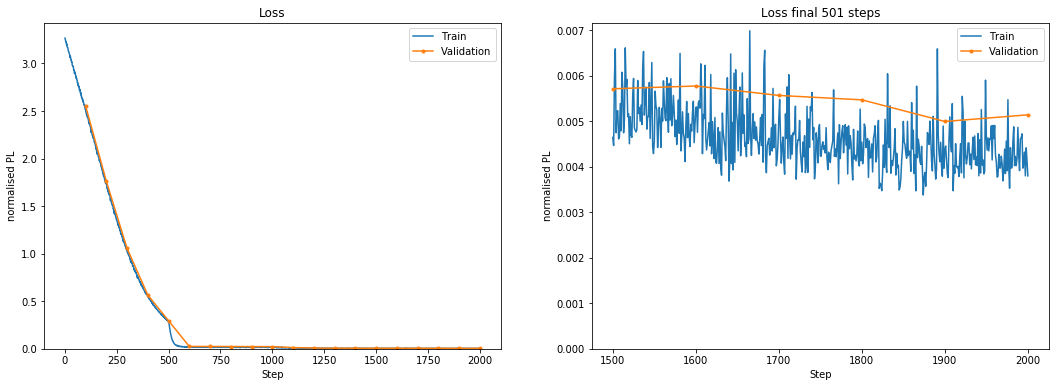

100/100 [==============================] - 48s 481ms/step - loss: 0.0043 - q0_loss: 2.5867e-05 - q1_loss: 1.1563e-04 - q2_loss: 5.3253e-04 - q3_loss: 7.0127e-04 - q4_loss: 9.5780e-04 - q5_loss: 8.6967e-04 - q6_loss: 7.3809e-04 - q7_loss: 2.5937e-04 - q8_loss: 9.8541e-05 - val_loss: 0.0051 - val_q0_loss: 3.6345e-05 - val_q1_loss: 1.6908e-04 - val_q2_loss: 6.8373e-04 - val_q3_loss: 8.8090e-04 - val_q4_loss: 0.0012 - val_q5_loss: 0.0010 - val_q6_loss: 8.3039e-04 - val_q7_loss: 2.4208e-04 - val_q8_loss: 7.4486e-05


In [39]:
# set lr (without recompiling and losing momentum)
def lr_scheduler(epoch, lr):
    return 1e-2
lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)

# train model
history = model.fit(train_batch_creator.flow(), epochs=5, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[lr_callback, logger])

In [42]:
model.set_weights(logger.best_model)

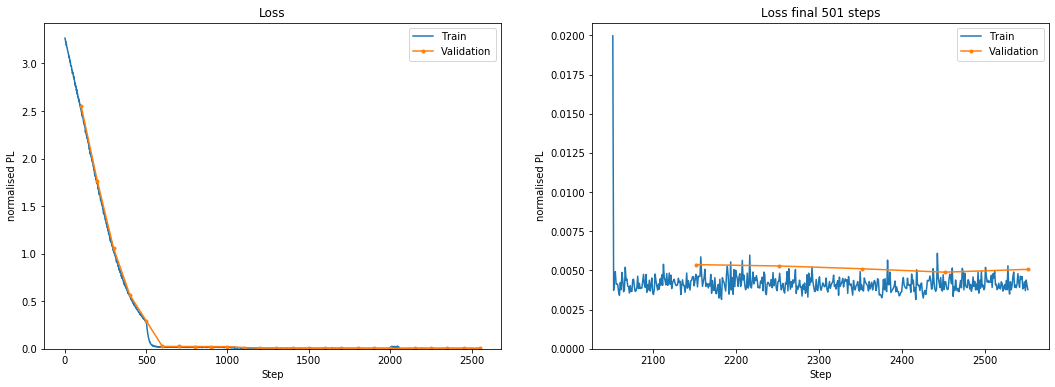

100/100 [==============================] - 48s 479ms/step - loss: 0.0042 - q0_loss: 2.5013e-05 - q1_loss: 1.1358e-04 - q2_loss: 5.1785e-04 - q3_loss: 6.8320e-04 - q4_loss: 9.3678e-04 - q5_loss: 8.4939e-04 - q6_loss: 7.1842e-04 - q7_loss: 2.4276e-04 - q8_loss: 8.2167e-05 - val_loss: 0.0051 - val_q0_loss: 3.6935e-05 - val_q1_loss: 1.6741e-04 - val_q2_loss: 6.8440e-04 - val_q3_loss: 8.7177e-04 - val_q4_loss: 0.0012 - val_q5_loss: 0.0010 - val_q6_loss: 8.2452e-04 - val_q7_loss: 2.5761e-04 - val_q8_loss: 7.0652e-05


In [43]:
# set lr (without recompiling and losing momentum)
def lr_scheduler(epoch, lr):
    return 1e-2
lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)

# train model
history = model.fit(train_batch_creator.flow(), epochs=5, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[lr_callback, logger])

**Fine-tune**

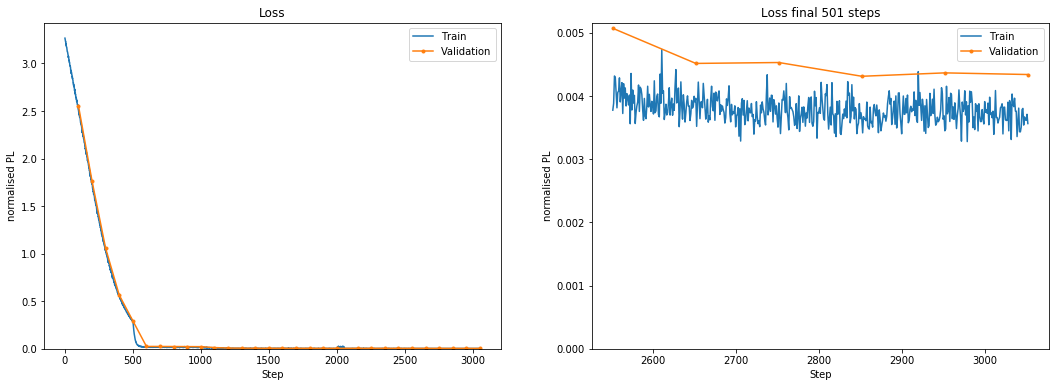

100/100 [==============================] - 88s 876ms/step - loss: 0.0037 - q0_loss: 2.5036e-05 - q1_loss: 1.1311e-04 - q2_loss: 4.8996e-04 - q3_loss: 6.3435e-04 - q4_loss: 8.4428e-04 - q5_loss: 7.4422e-04 - q6_loss: 6.1720e-04 - q7_loss: 1.9412e-04 - q8_loss: 6.4524e-05 - val_loss: 0.0043 - val_q0_loss: 3.6564e-05 - val_q1_loss: 1.6225e-04 - val_q2_loss: 6.0716e-04 - val_q3_loss: 7.7136e-04 - val_q4_loss: 9.9430e-04 - val_q5_loss: 8.3847e-04 - val_q6_loss: 6.8153e-04 - val_q7_loss: 1.9324e-04 - val_q8_loss: 5.4889e-05


In [44]:
# set batch size to 5.000
train_batch_creator, val_batch_creator = get_generators(batch_size=5000)

# set lr (without recompiling and losing momentum)
def lr_scheduler(epoch, lr):
    return 1e-3
lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)

# train model
history = model.fit(train_batch_creator.flow(), epochs=5, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[lr_callback, logger])

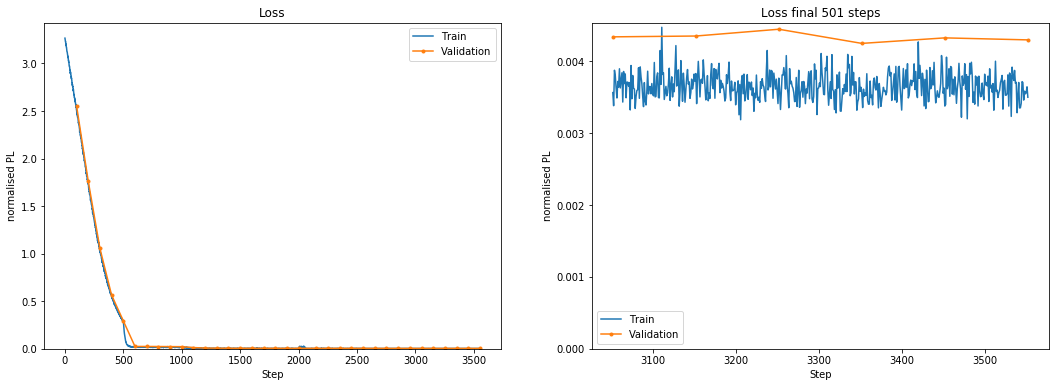

100/100 [==============================] - 90s 897ms/step - loss: 0.0036 - q0_loss: 2.4459e-05 - q1_loss: 1.1085e-04 - q2_loss: 4.7965e-04 - q3_loss: 6.2176e-04 - q4_loss: 8.2936e-04 - q5_loss: 7.2925e-04 - q6_loss: 6.0287e-04 - q7_loss: 1.8517e-04 - q8_loss: 5.9880e-05 - val_loss: 0.0043 - val_q0_loss: 3.6424e-05 - val_q1_loss: 1.5957e-04 - val_q2_loss: 6.0148e-04 - val_q3_loss: 7.6671e-04 - val_q4_loss: 9.8428e-04 - val_q5_loss: 8.3209e-04 - val_q6_loss: 6.7514e-04 - val_q7_loss: 1.8807e-04 - val_q8_loss: 5.3813e-05


In [45]:
# train model
history = model.fit(train_batch_creator.flow(), epochs=5, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[lr_callback, logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{10: 0.21137236159635017, 'WSPL': 0.21137236159635017}


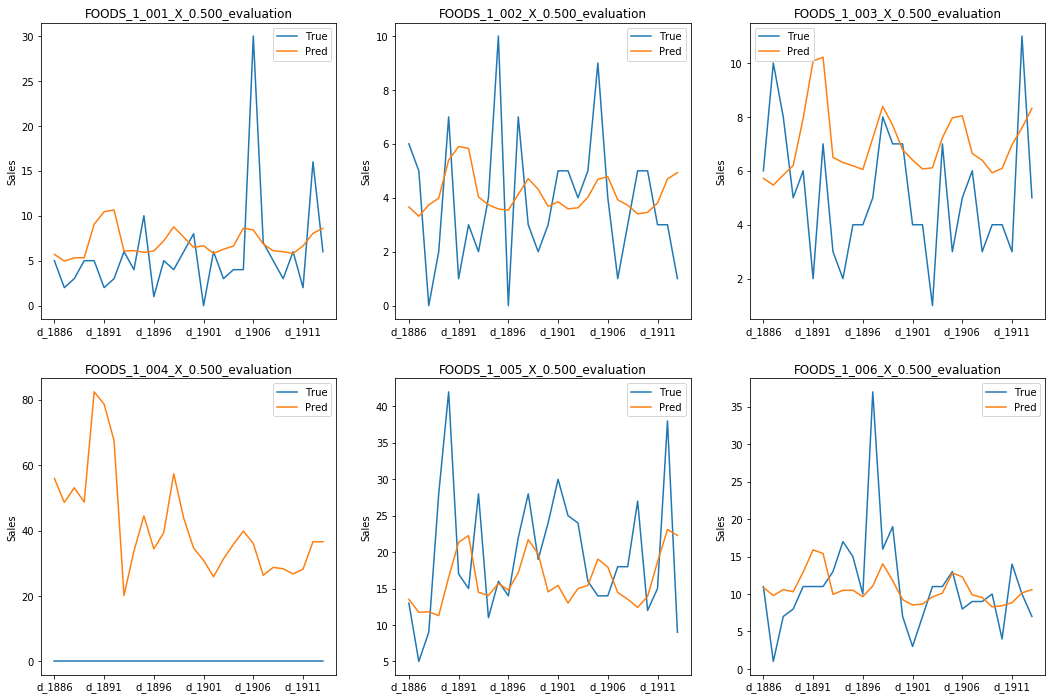

In [46]:
model.save_weightssave_weightssave(model_dir + "model_direct_dist_256_manual_lr_to_1e-3_finetune_bs5k.h5")
# calculate WSPL and save metrics
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

**Decrease lr**

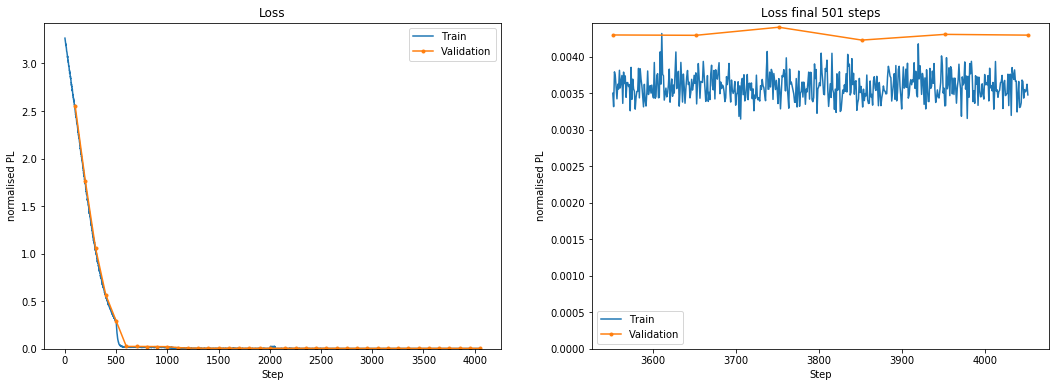

100/100 [==============================] - 76s 759ms/step - loss: 0.0036 - q0_loss: 2.4315e-05 - q1_loss: 1.1000e-04 - q2_loss: 4.7447e-04 - q3_loss: 6.1489e-04 - q4_loss: 8.1977e-04 - q5_loss: 7.1820e-04 - q6_loss: 5.9291e-04 - q7_loss: 1.7939e-04 - q8_loss: 5.7447e-05 - val_loss: 0.0043 - val_q0_loss: 3.6401e-05 - val_q1_loss: 1.5912e-04 - val_q2_loss: 6.0315e-04 - val_q3_loss: 7.6804e-04 - val_q4_loss: 9.8489e-04 - val_q5_loss: 8.3097e-04 - val_q6_loss: 6.7324e-04 - val_q7_loss: 1.8615e-04 - val_q8_loss: 5.3366e-05


In [48]:
# set lr (without recompiling and losing momentum)
def lr_scheduler(epoch, lr):
    return 1e-4
lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)

# train model
history = model.fit(train_batch_creator.flow(), epochs=5, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[lr_callback, logger])

### Visualise some predictions

In [202]:
model = get_direct_dist_model(inp_shape=INP_SHAPE, num_nodes=256)
model.set_weights(model_dir + "model_direct_dist_256_manual_lr_to_1e-3_finetune_bs5k.h5")
# calculate WSPL and save metrics
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 3237)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          828928      input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          65792       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          65792       dense_1[0][0]                    
______________________________________________________________________________________________

ValueError: You called `set_weights(weights)` on layer "model" with a  weight list of length 94, but the layer was expecting 24 weights. Provided weights: models/uncertainty/hyper_opt/level_10/model_direct...

## Network size

### 512 nodes

In [50]:
# set batch size
train_batch_creator, val_batch_creator = get_generators()

# setup metric tracking
logger = Logger(val_batch_creator)

model = get_direct_dist_model(inp_shape=INP_SHAPE, num_nodes=512)
model.compile(optimizer=Adam(1e-5), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 3237)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          1657856     input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          262656      dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 512)          262656      dense_1[0][0]                    
______________________________________________________________________________________________

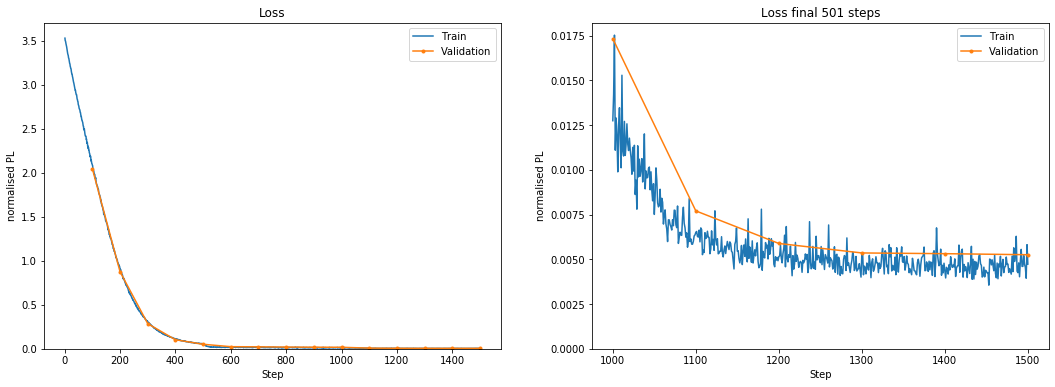

100/100 [==============================] - 54s 537ms/step - loss: 0.0046 - q0_loss: 2.3770e-05 - q1_loss: 1.1633e-04 - q2_loss: 5.9286e-04 - q3_loss: 7.7211e-04 - q4_loss: 0.0010 - q5_loss: 9.2406e-04 - q6_loss: 7.7722e-04 - q7_loss: 2.7550e-04 - q8_loss: 1.1047e-04 - val_loss: 0.0053 - val_q0_loss: 3.5547e-05 - val_q1_loss: 1.7654e-04 - val_q2_loss: 6.7351e-04 - val_q3_loss: 8.9650e-04 - val_q4_loss: 0.0012 - val_q5_loss: 0.0010 - val_q6_loss: 8.9105e-04 - val_q7_loss: 2.8914e-04 - val_q8_loss: 9.7640e-05


In [51]:
lr_list = [1e-5, 1e-4, 1e-3]

for lr_block in lr_list:
    # set lr (without recompiling and losing momentum)
    def lr_scheduler(epoch, lr):
        return lr_block
    lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
    
    # train model
    history = model.fit(train_batch_creator.flow(), epochs=5, steps_per_epoch=100,
                        validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                        callbacks=[lr_callback, logger])

In [58]:
## Increasing the lr to 1e-2 broke the model. 

## CLR

In [60]:
def get_lr_test_scheduler(lr_start, lr_max, num):
    """LR test scheduler function. Ramps up linearly from lr_start to lr_max.
    To be combined with tf.keras.callbacks.LearningRateScheduler"""
    def lr_test_scheduler(epoch, lr):
        lr_range = np.linspace(lr_start, lr_max, num=num)
        lr = lr_range[epoch]
        return lr
    return lr_test_scheduler


def get_pyramid_lr(lr_start=0.01, lr_max=0.5, n_epoch=100, n_epochs_end=10):
    """LR pyramidal scheduler function. Ramps up linearly from lr_start to lr_max,
    then back to lr_start and finished with an additional slope to 1/10th of lr_start.
    To be combined with tf.keras.callbacks.LearningRateScheduler"""
    def lr_pyramid_scheduler(epoch, lr):
        n_epoch_half_pyramid = int(np.ceil(n_epoch/2 - n_epochs_end/2))
        lr_range = np.concatenate((
            np.linspace(lr_start, lr_max, num=n_epoch_half_pyramid),
            np.linspace(lr_max, lr_start, num=n_epoch_half_pyramid),
            np.linspace(lr_start, lr_start/10, num=n_epochs_end)))
        lr = lr_range[epoch]
        return lr
    return lr_pyramid_scheduler

### Test

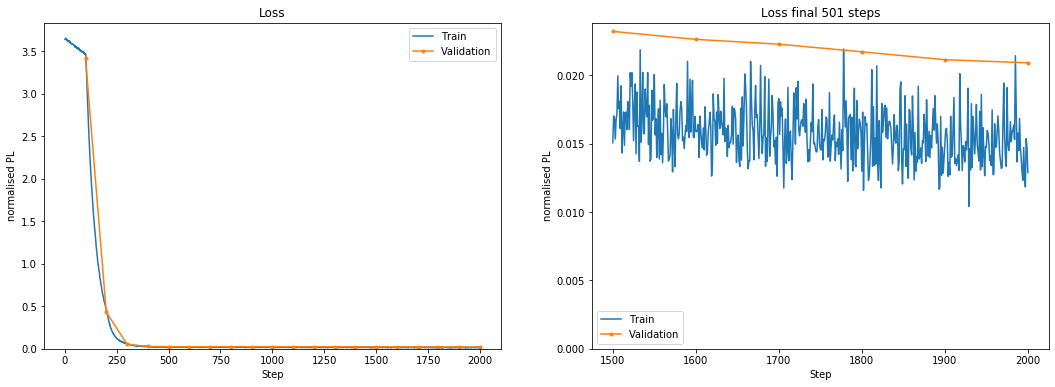

100/100 [==============================] - 49s 490ms/step - loss: 0.0150 - q0_loss: 2.0441e-04 - q1_loss: 3.4721e-04 - q2_loss: 9.6559e-04 - q3_loss: 0.0015 - q4_loss: 0.0023 - q5_loss: 0.0029 - q6_loss: 0.0029 - q7_loss: 0.0020 - q8_loss: 0.0020 - val_loss: 0.0209 - val_q0_loss: 7.8916e-05 - val_q1_loss: 2.3233e-04 - val_q2_loss: 0.0012 - val_q3_loss: 0.0017 - val_q4_loss: 0.0031 - val_q5_loss: 0.0040 - val_q6_loss: 0.0040 - val_q7_loss: 0.0031 - val_q8_loss: 0.0034


In [64]:
# set batch size to 1024
train_batch_creator, val_batch_creator = get_generators()

# setup metric tracking
logger = Logger(val_batch_creator)

model = get_direct_dist_model(inp_shape=INP_SHAPE, num_nodes=256)
model.compile(optimizer=SGD(1e-5, momentum=0.75, nesterov=True), loss=losses)

# setup lr scheduler
epochs = 20
lr_func = get_lr_test_scheduler(lr_start=1e-5, lr_max=1e-2, num=epochs)
lr_callback = LearningRateScheduler(lr_func, verbose=1)

# train model
history = model.fit(train_batch_creator.flow(), epochs=epochs, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[lr_callback, logger])

### Re-test with lower slope and higher momentum

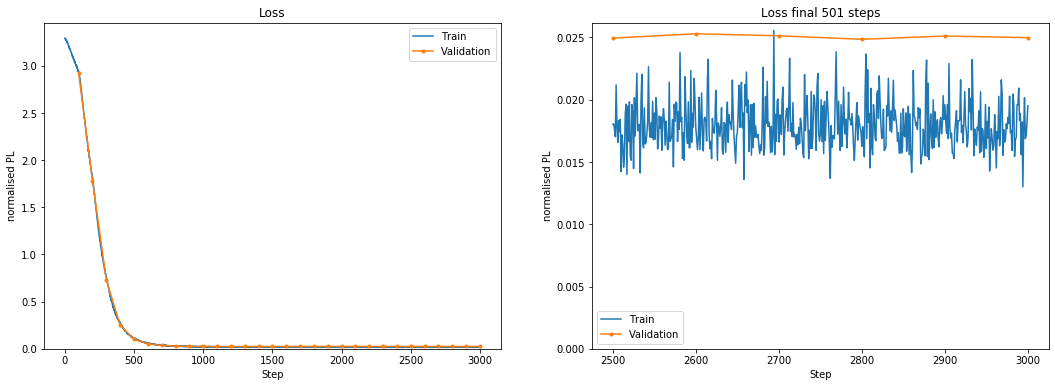

100/100 [==============================] - 48s 479ms/step - loss: 0.0178 - q0_loss: 2.0989e-04 - q1_loss: 4.3877e-04 - q2_loss: 0.0011 - q3_loss: 0.0017 - q4_loss: 0.0025 - q5_loss: 0.0029 - q6_loss: 0.0030 - q7_loss: 0.0030 - q8_loss: 0.0030 - val_loss: 0.0250 - val_q0_loss: 7.7965e-05 - val_q1_loss: 2.6287e-04 - val_q2_loss: 0.0012 - val_q3_loss: 0.0018 - val_q4_loss: 0.0031 - val_q5_loss: 0.0043 - val_q6_loss: 0.0046 - val_q7_loss: 0.0048 - val_q8_loss: 0.0049


In [65]:
# set batch size to 1024
train_batch_creator, val_batch_creator = get_generators()

# setup metric tracking
logger = Logger(val_batch_creator)

model = get_direct_dist_model(inp_shape=INP_SHAPE, num_nodes=256)
model.compile(optimizer=SGD(1e-5, momentum=0.9, nesterov=True), loss=losses)

# setup lr scheduler
epochs = 30
lr_func = get_lr_test_scheduler(lr_start=1e-5, lr_max=1e-3, num=epochs)
lr_callback = LearningRateScheduler(lr_func, verbose=1)

# train model
history = model.fit(train_batch_creator.flow(), epochs=epochs, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[lr_callback, logger])

### Re-test with Adam optimiser

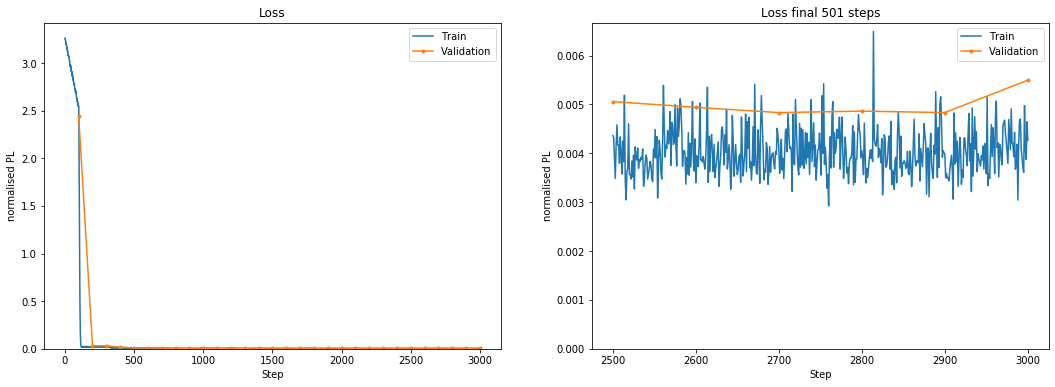

100/100 [==============================] - 46s 459ms/step - loss: 0.0040 - q0_loss: 2.3670e-05 - q1_loss: 1.1438e-04 - q2_loss: 5.0617e-04 - q3_loss: 6.6456e-04 - q4_loss: 9.1392e-04 - q5_loss: 8.2749e-04 - q6_loss: 6.9601e-04 - q7_loss: 2.2773e-04 - q8_loss: 7.1273e-05 - val_loss: 0.0055 - val_q0_loss: 3.5547e-05 - val_q1_loss: 1.6960e-04 - val_q2_loss: 7.0185e-04 - val_q3_loss: 9.0968e-04 - val_q4_loss: 0.0013 - val_q5_loss: 0.0011 - val_q6_loss: 9.3644e-04 - val_q7_loss: 2.5911e-04 - val_q8_loss: 7.7563e-05


In [66]:
# set batch size to 1024
train_batch_creator, val_batch_creator = get_generators()

# setup metric tracking
logger = Logger(val_batch_creator)

model = get_direct_dist_model(inp_shape=INP_SHAPE, num_nodes=256)
model.compile(optimizer="adam", loss=losses)

# setup lr scheduler
epochs = 30
lr_func = get_lr_test_scheduler(lr_start=1e-4, lr_max=1e-2, num=epochs)
lr_callback = LearningRateScheduler(lr_func, verbose=1)

# train model
history = model.fit(train_batch_creator.flow(), epochs=epochs, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[lr_callback, logger])

## Predicted distribution

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{10: 0.26381959865091065, 'WSPL': 0.26381959865091065}


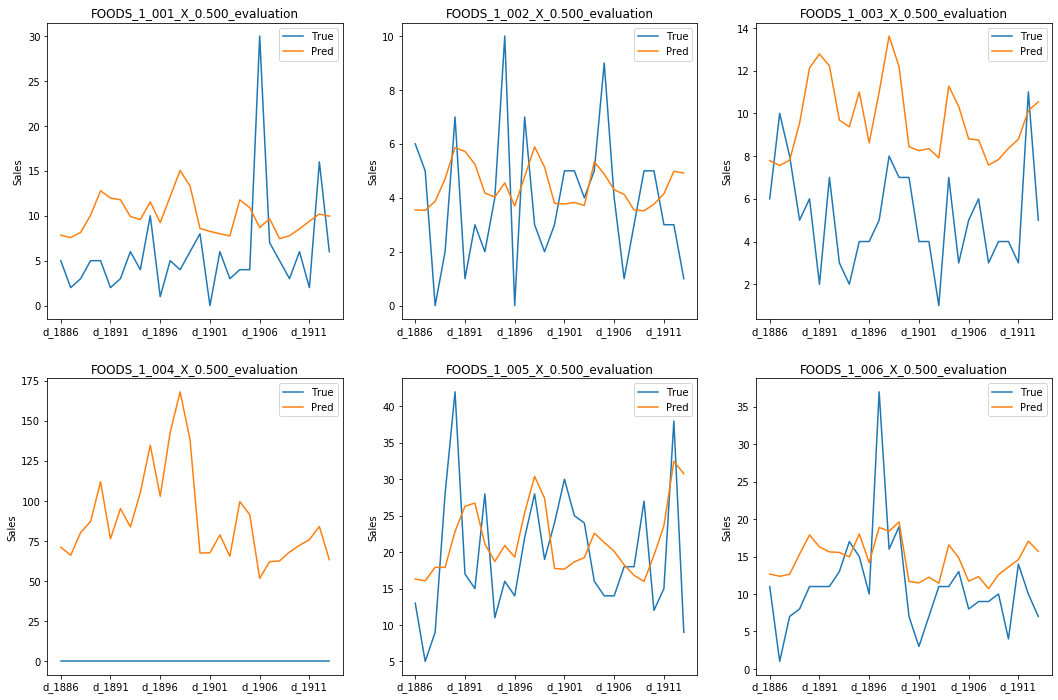

In [92]:
# calculate WSPL
metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)

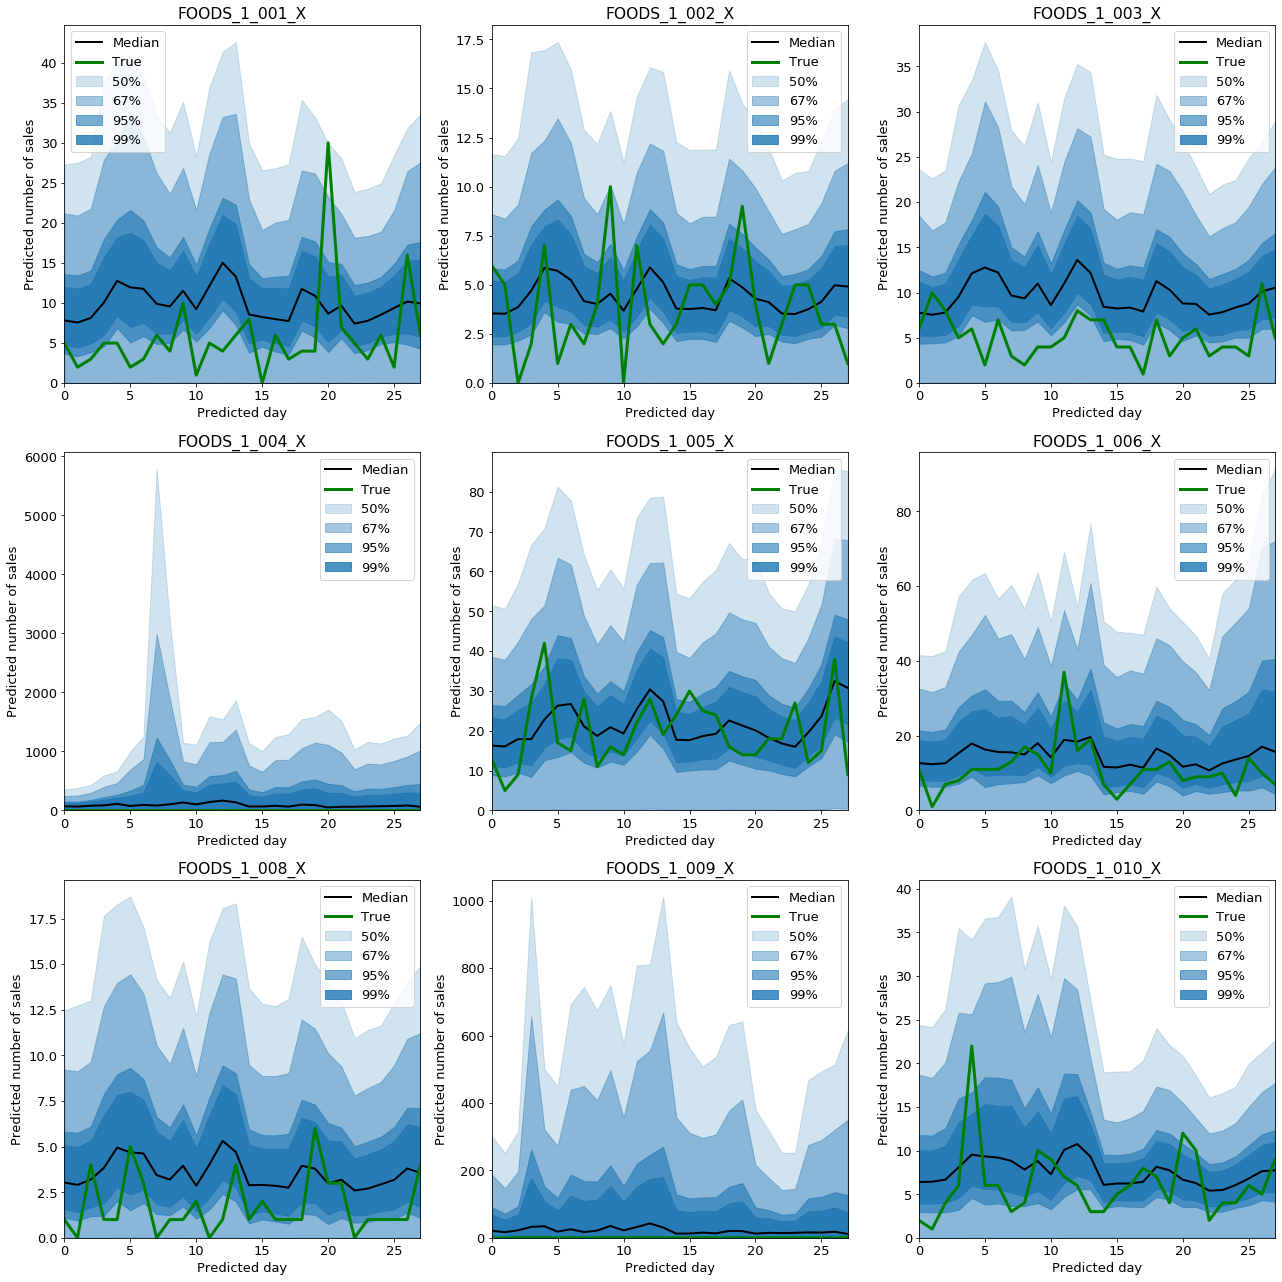

In [193]:
plot_some_confidence_intervals(df, val_batch_creator, level, data_dir)